In [1]:
import pathlib
import numpy as np
import scipy as sp
import pandas as pd
from matplotlib import pyplot as plt




import SessionTools.two_photon as st2p
import NeuromodPlasticity as nmp


plt.rcParams['pdf.fonttype']=42

%load_ext autoreload
%autoreload 2 


%matplotlib inline


In [2]:
basedir = pathlib.Path('/media/mplitt/SSD_storage/2P_scratch/R18B05LexA_CsChrimsontdT_R60D05Gal4_jGCaMP7f/remapping')
sess_df = pd.read_csv(basedir / 'sessions.csv')
sess_df = sess_df.iloc[:-1]
print(sess_df.columns)
sess_df['fly_id'] = [row['date']+'_'+row['fly'] +'_' + row['condition'] for _, row in sess_df.iterrows()]
sess_df['mean offset'] = [np.nan for _, row in sess_df.iterrows()]
sess_df['offset var.'] = [np.nan for _, row in sess_df.iterrows()]
sess_df['mean vec. len'] = [np.nan for _, row in sess_df.iterrows()]


figfolder = pathlib.Path('/media/mplitt/SSD_storage/fig_scratch/R18B05LexA_CsChrimsontdT_R60D05Gal4_jGCaMP7f')
figfolder.mkdir(parents=True, exist_ok=True)

Index(['date', 'fly', 'sess', 'fictrac_scan_num', 'fictrac_file', 'condition',
       'scan_type', 'usable', 'notes'],
      dtype='object')


In [3]:
sess_df.head()

date   fly              sess  fictrac_scan_num  \
0  11_07_2024  fly1      baseline-000                 0   
1  11_07_2024  fly1    remap_0deg-001                 1   
2  11_07_2024  fly1     post_0deg-002                 2   
3  11_07_2024  fly1  remap_180deg-004                 4   
4  11_07_2024  fly1   post_180deg-006                 6   

                  fictrac_file condition     scan_type  usable notes  \
0  fictrac-20240711_112205.dat     remap      baseline     NaN   NaN   
1  fictrac-20240711_112205.dat     remap    remap_0deg     NaN   NaN   
2  fictrac-20240711_112205.dat     remap     post_0deg     NaN   NaN   
3  fictrac-20240711_112205.dat     remap  remap_180deg     NaN   NaN   
4  fictrac-20240711_112205.dat     remap   post_180deg     NaN   NaN   

                  fly_id  mean offset  offset var.  mean vec. len  
0  11_07_2024_fly1_remap          NaN          NaN            NaN  
1  11_07_2024_fly1_remap          NaN          NaN            NaN  
2  11_07_2024_fly1_remap          NaN          NaN            NaN  
3  11_07_2024_fly1_remap          NaN          NaN            NaN  
4  11_07_2024_fly1_remap          NaN          NaN            NaN

In [4]:
def load_row(row):
    outdir = pathlib.PurePath( basedir / row['condition'] / row['date'] / row['fly'] / row['sess'] / 'preprocess.pkl')
    return st2p.preprocessing.EBImagingSession.from_file(outdir)

In [5]:
opto_responses = {
    'remap': {'remap_0deg': [], 'remap_180deg': [], 'combined':[]}, 
    'no_chrimson': {'remap_0deg': [], 'remap_180deg': [], 'combined': []}, 
    'novis_control': {'remap_novis': []},
}

##
sess_df_remap0 = sess_df.loc[sess_df['scan_type']=='remap_0deg']
remap = sess_df_remap0.loc[sess_df_remap0['condition']=='remap']
opto_responses['remap']['remap_0deg'] = np.stack([nmp.remapping.get_opto_resp(load_row(row)) for _, row in remap.iterrows()])

no_chrimson = sess_df_remap0.loc[sess_df_remap0['condition']=='no_chrimson']
opto_responses['no_chrimson']['remap_0deg'] = np.stack([nmp.remapping.get_opto_resp(load_row(row)) for _, row in no_chrimson.iterrows()]) 

##
sess_df_remap180 = sess_df.loc[sess_df['scan_type']=='remap_180deg']
remap = sess_df_remap180.loc[sess_df_remap180['condition']=='remap']
opto_responses['remap']['remap_180deg'] = np.stack([nmp.remapping.get_opto_resp(load_row(row)) for _, row in remap.iterrows()])

no_chrimson = sess_df_remap180.loc[sess_df_remap180['condition']=='no_chrimson']
opto_responses['no_chrimson']['remap_180deg'] = np.stack([nmp.remapping.get_opto_resp(load_row(row)) for _, row in no_chrimson.iterrows()]) 

opto_responses['remap']['combined'] = (opto_responses['remap']['remap_0deg'] + opto_responses['remap']['remap_180deg'])/2
opto_responses['no_chrimson']['combined'] = (opto_responses['no_chrimson']['remap_0deg'] + opto_responses['no_chrimson']['remap_180deg'])/2

##
novis = sess_df.loc[(sess_df['condition']=='novis_control') * (sess_df['scan_type']=='remap_novis')]
opto_responses['novis_control']['remap_novis'] = np.stack([nmp.remapping.get_opto_resp(load_row(row)) for _, row in novis.iterrows()]) 



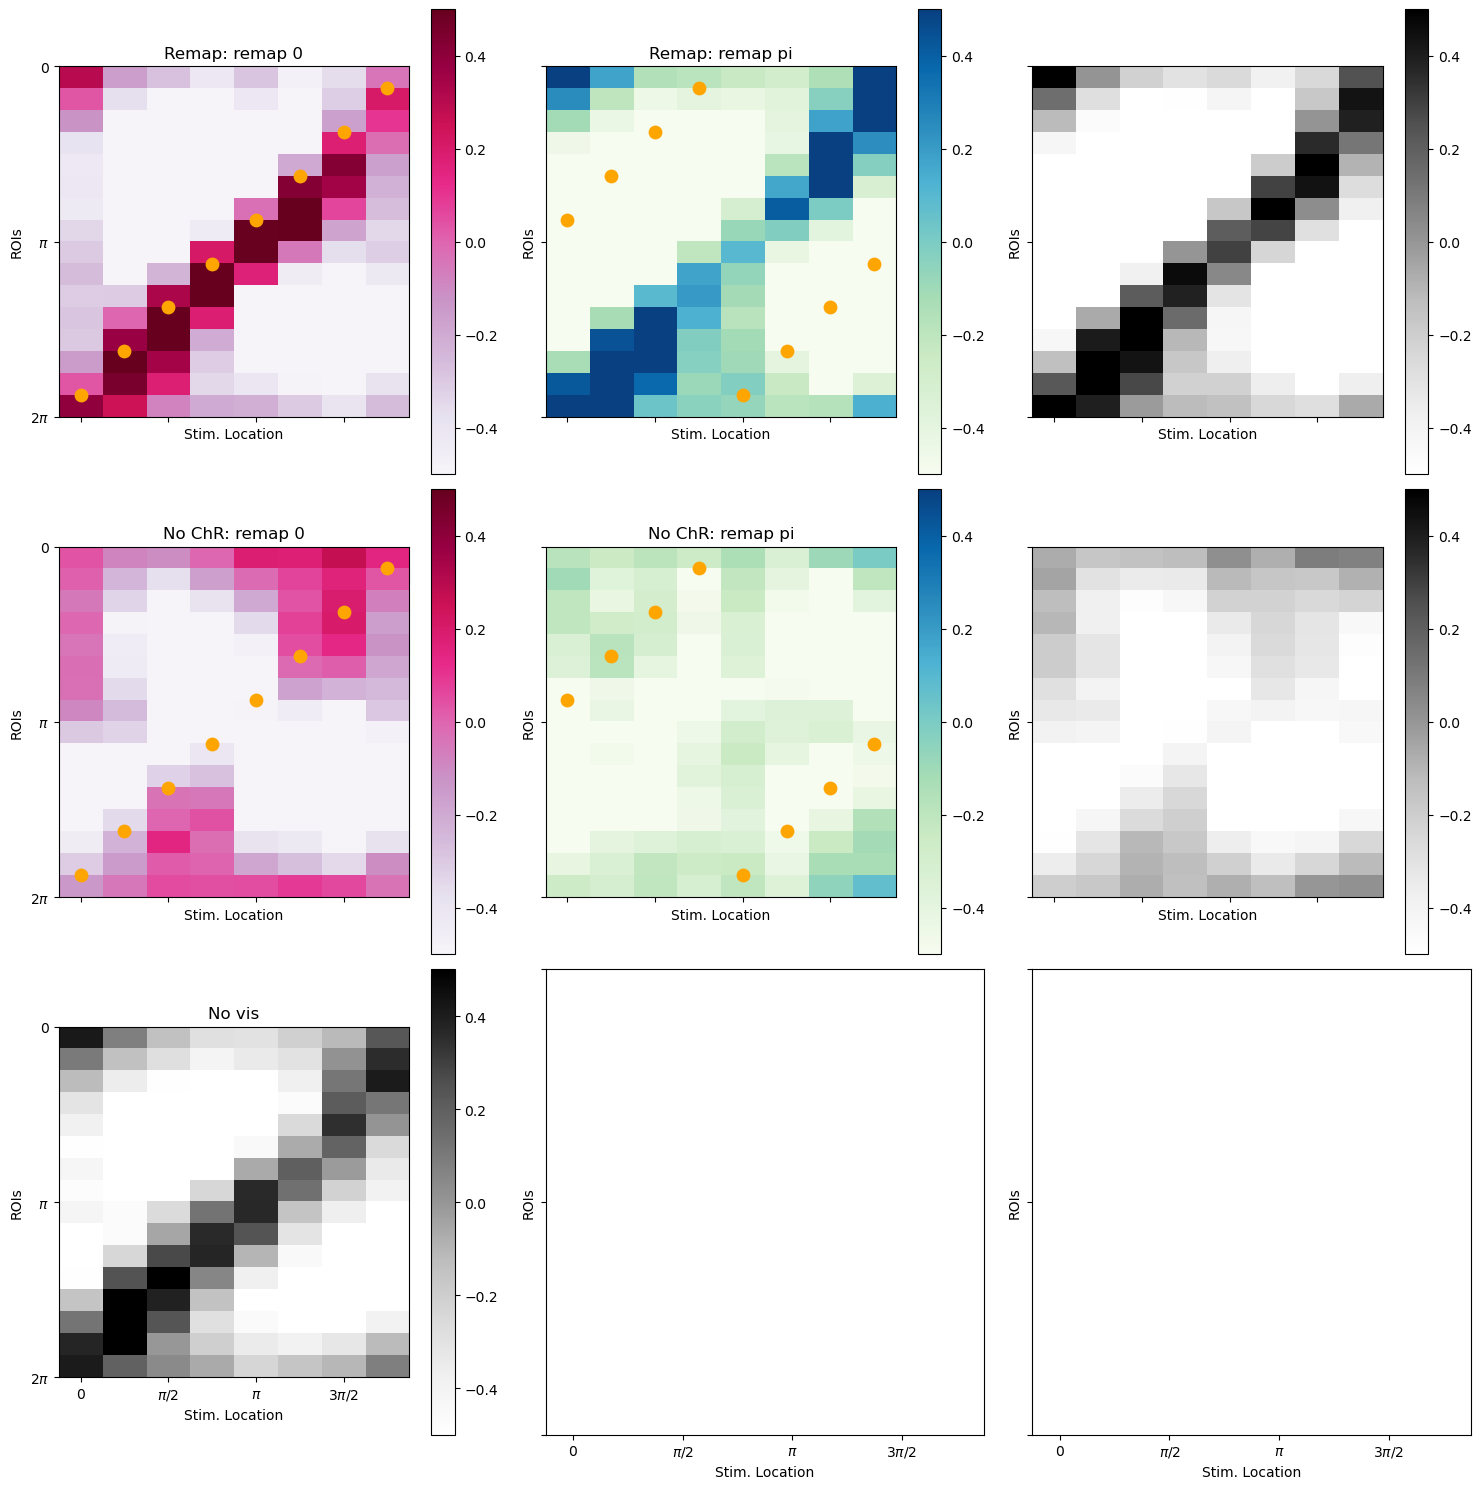

In [6]:
fig, ax = plt.subplots(3,3,figsize=[15,15],sharex=True,sharey=True)
h = ax[0,0].imshow(np.nanmean(opto_responses['remap']['remap_0deg'],axis=(0,3)),aspect=.5, vmin=-.5, vmax=.5, cmap='PuRd')
fig.colorbar(h, ax=ax[0,0])
h = ax[0,1].imshow(np.nanmean(opto_responses['remap']['remap_180deg'],axis=(0,3)),aspect=.5, vmin=-.5, vmax=.5, cmap='GnBu')
fig.colorbar(h, ax=ax[0,1])
h = ax[0,2].imshow(np.nanmean(opto_responses['remap']['combined'],axis=(0,3)),aspect=.5, vmin=-.5, vmax=.5, cmap='Greys')
fig.colorbar(h, ax=ax[0,2])

ax[0, 0].set_title('Remap: remap 0')
ax[0, 1].set_title('Remap: remap pi')



h = ax[1,0].imshow(np.nanmean(opto_responses['no_chrimson']['remap_0deg'],axis=(0,3)),aspect=.5, vmin=-.5, vmax=.5, cmap='PuRd')
fig.colorbar(h, ax=ax[1,0])
h = ax[1,1].imshow(np.nanmean(opto_responses['no_chrimson']['remap_180deg'],axis=(0,3)),aspect=.5, vmin=-.5, vmax=.5, cmap='GnBu')
fig.colorbar(h, ax=ax[1,1])
h = ax[1,2].imshow(np.nanmean(opto_responses['no_chrimson']['combined'],axis=(0,3)),aspect=.5, vmin=-.5, vmax=.5, cmap='Greys')
fig.colorbar(h, ax=ax[1,2])

ax[1, 0].set_title('No ChR: remap 0')
ax[1, 1].set_title('No ChR: remap pi')

h = ax[2,0].imshow(np.nanmean(opto_responses['novis_control']['remap_novis'],axis=(0,3)), aspect=.5, vmin=-.5, vmax=.5, cmap='Greys')
fig.colorbar(h, ax=ax[2,0])

ax[2,0].set_title('No vis')


for r in range(2):
    x = np.arange(8)
    y = np.arange(0,2*np.pi,np.pi/4)[::-1]*8/np.pi+.5
    h = ax[r,0].scatter(x,y,color= 'orange',s=80)


    y = np.roll(y,4)
    ax[r,1].scatter(x,y,color='orange',s=80)
    

for a in ax.flatten():
    a.set_ylabel('ROIs')
    a.set_xlabel('Stim. Location')
    
    a.set_xticks([0,2,4,6], labels=[r'0',r'$\pi$/2', r'$\pi$', r'3$\pi$/2'])
    a.set_yticks([-.5,7.5,15.5], labels=[r'0',r'$\pi$', r'2$\pi$'])

fig.tight_layout()
fig.savefig( figfolder / 'opto_resp_heatmaps.pdf')

In [7]:
opto_resp_al = {}
for ck in ('remap', 'no_chrimson', 'novis_control'):
    opto_resp_al[ck] = {}
    for rk in opto_responses[ck].keys():
        opto = np.copy(opto_responses[ck][rk])
        for i in range(8):
            opto[:,:,i,:] = np.roll(opto[:,:,i,:],2*i-8, axis=1)
            
        opto_resp_al[ck][rk] = opto

59.0 0.48796009631922954
134.0 0.0002006638466493768


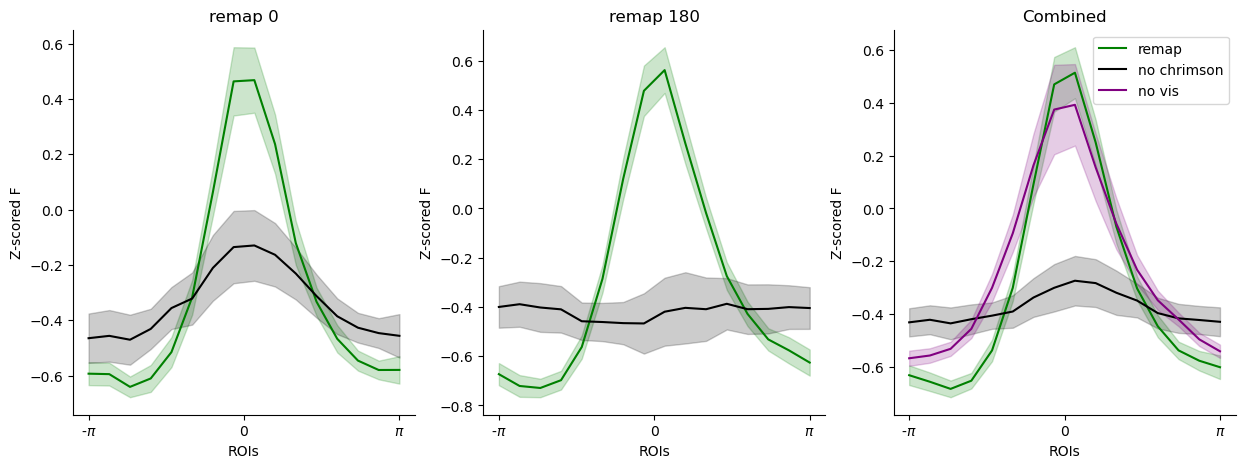

In [8]:
fig, ax = plt.subplots(1,3, figsize=[15,5])
x = np.linspace(-np.pi, np.pi, num=16)

remap_resp = opto_resp_al['remap']['remap_0deg'].mean(axis=(2,3))
nochrimson_resp = opto_resp_al['no_chrimson']['remap_0deg'].mean(axis=(2,3))

mu, sem = remap_resp.mean(axis=0), sp.stats.sem(remap_resp, axis=0)
ax[0].plot(x, mu, color='green')
ax[0].fill_between(x, mu-sem, mu+sem, color='green', alpha=.2)

mu, sem = nochrimson_resp.mean(axis=0), sp.stats.sem(nochrimson_resp, axis=0)
ax[0].plot(x, mu, color='black')
ax[0].fill_between(x, mu-sem, mu+sem, color='black', alpha=.2)

ax[0].set_title('remap 0')

remap_resp = opto_resp_al['remap']['remap_180deg'].mean(axis=(2,3))
nochrimson_resp = opto_resp_al['no_chrimson']['remap_180deg'].mean(axis=(2,3))

mu, sem = remap_resp.mean(axis=0), sp.stats.sem(remap_resp, axis=0)
ax[1].plot(x, mu, color='green')
ax[1].fill_between(x, mu-sem, mu+sem, color='green', alpha=.2)

mu, sem = nochrimson_resp.mean(axis=0), sp.stats.sem(nochrimson_resp, axis=0)
ax[1].plot(x, mu, color='black')
ax[1].fill_between(x, mu-sem, mu+sem, color='black', alpha=.2)

ax[1].set_title('remap 180')

remap_resp = np.stack((opto_resp_al['remap']['remap_0deg'].mean(axis=(2,3)), opto_resp_al['remap']['remap_180deg'].mean(axis=(2,3)))).mean(axis=0)
nochrimson_resp = np.stack((opto_resp_al['no_chrimson']['remap_0deg'].mean(axis=(2,3)), opto_resp_al['no_chrimson']['remap_180deg'].mean(axis=(2,3)))).mean(axis=0)
novis_resp = ((opto_resp_al['novis_control']['remap_novis'][::2,:,:,:] + opto_resp_al['novis_control']['remap_novis'][1::2,:,:,:])/2).mean(axis=(2,3))

mu, sem = remap_resp.mean(axis=0), sp.stats.sem(remap_resp, axis=0)
ax[2].plot(x, mu, color='green', label='remap')
ax[2].fill_between(x, mu-sem, mu+sem, color='green', alpha=.2)

mu, sem = nochrimson_resp.mean(axis=0), sp.stats.sem(nochrimson_resp, axis=0)
ax[2].plot(x, mu, color='black', label='no chrimson')
ax[2].fill_between(x, mu-sem, mu+sem, color='black', alpha=.2)

mu, sem = novis_resp.mean(axis=0), sp.stats.sem(novis_resp, axis=0)
ax[2].plot(x, mu, color='purple', label='no vis')
ax[2].fill_between(x, mu-sem, mu+sem, color='purple', alpha=.2)
ax[2].set_title('Combined')
ax[2].legend()


# t,p = sp.stats.mannwhitneyu(np.linalg.norm(remap_resp, axis=-1), 
#                             np.linalg.norm(novis_resp, axis=-1))

# print(t,p)

# t,p = sp.stats.mannwhitneyu(np.linalg.norm(remap_resp, axis=-1), 
#                             np.linalg.norm(nochrimson_resp, axis=-1))

# print(t,p)

t,p = sp.stats.mannwhitneyu(remap_resp[:,7:10].mean(axis=-1),
                            novis_resp[:,7:10].mean(axis=-1))

print(t,p)

t,p = sp.stats.mannwhitneyu(remap_resp[:,7:10].mean(axis=-1),
                            nochrimson_resp[:,7:10].mean(axis=-1))

print(t,p)

for a in ax.flatten():
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)

    a.set_ylabel('Z-scored F')
    a.set_xlabel('ROIs')

    _ = a.set_xticks([-np.pi, 0, np.pi], labels = [r'-$\pi$', '0', r'$\pi$'])

fig.savefig( figfolder / "aligned_opto_resp.pdf")

In [9]:
nonremap_sess_df = sess_df.loc[(sess_df['scan_type']=='baseline') | \
                               (sess_df['scan_type']=='post_0deg') | \
                               (sess_df['scan_type']=='post_180deg') | \
                               (sess_df['scan_type']=='post_novis1') | \
                               (sess_df['scan_type']=='post_novis2')]
flies = nonremap_sess_df['fly_id'].unique()
for index,row in nonremap_sess_df.iterrows():
    ts = nmp.session.GetTS(load_row(row))
    
    
    offset_c_mu = ts.offset_c.mean()
    
    sess_df.loc[index, 'mean offset'] = np.angle(offset_c_mu)
    sess_df.loc[index, 'mean vec. len'] = np.abs(offset_c_mu)
    sess_df.loc[index, 'offset var.'] = sp.stats.circvar(ts.offset)

In [11]:
sess_df.head()
sess_df['condition'].unique()

array(['remap', 'novis_control', 'no_chrimson', 'epinastine', 'yohimbine'],
      dtype=object)

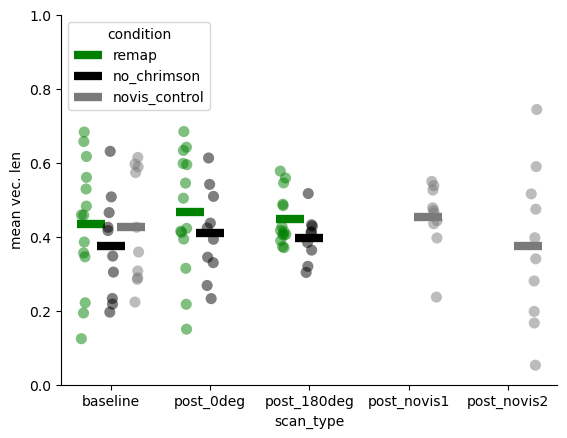

In [14]:
import seaborn as sns
fig, ax = plt.subplots()

colors = ['green', 'black', plt.cm.Greys(.6)]
tmp_sess_df = sess_df.loc[sess_df['scan_type'].isin(('baseline', 'post_0deg', 'post_180deg', 'post_novis1', 'post_novis2'))]
tmp_sess_df = tmp_sess_df.loc[tmp_sess_df['condition'].isin(('remap', 'no_chrimson', 'novis_control'))]

sns.stripplot(data=tmp_sess_df, x='scan_type', y='mean vec. len', ax=ax, alpha=.5,
            dodge=True, palette=colors, hue='condition', s=8, legend=False,
            hue_order=['remap', 'no_chrimson', 'novis_control'])
sns.pointplot(data=tmp_sess_df, x='scan_type', y='mean vec. len', ax=ax, 
              hue='condition', palette=colors, hue_order=['remap', 'no_chrimson', 'novis_control'],
              estimator=np.mean, errorbar=None, marker='_', markersize=20, 
              markeredgewidth=6, legend=True, dodge=.4, linestyle='none')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim([0,1])
fig.savefig(figfolder / "remapping_vec_len_comparison.pdf")


In [30]:
def build_sum_stats(fly_list):
    sum_stats = {'fly_id': []}
    if not 'novis' in fly_list[0]:
        for s in ('baseline', 'post_0deg', 'post_180deg'):
            sum_stats[f'{s} mean offset'] = []
            sum_stats[f'{s} vec. len'] = []
            sum_stats[f'{s} offset var.'] = []
            
    else:
            
        for s in ('baseline', 'post_novis1', 'post_novis2'):
            sum_stats[f'{s} mean offset'] = []
            sum_stats[f'{s} vec. len'] = []
            sum_stats[f'{s} offset var.'] = []
                
    
    
    
    for fly in fly_list:
        sum_stats['fly_id'].append(fly)
        
        if not 'novis' in fly:
            for s in ('baseline', 'post_0deg', 'post_180deg'):
                sum_stats[f'{s} mean offset'].append(sess_df.loc[(sess_df['fly_id']==fly) & (sess_df['scan_type']==s)]['mean offset'].mean())
                sum_stats[f'{s} vec. len'].append(sess_df.loc[(sess_df['fly_id']==fly) & (sess_df['scan_type']==s)]['mean vec. len'].mean())
                sum_stats[f'{s} offset var.'].append(sess_df.loc[(sess_df['fly_id']==fly) & (sess_df['scan_type']==s)]['offset var.'].mean())
        else:
            for s in ('baseline', 'post_novis1', 'post_novis2'):
                sum_stats[f'{s} mean offset'].append(sess_df.loc[(sess_df['fly_id']==fly) & (sess_df['scan_type']==s)]['mean offset'].mean())
                sum_stats[f'{s} vec. len'].append(sess_df.loc[(sess_df['fly_id']==fly) & (sess_df['scan_type']==s)]['mean vec. len'].mean())
                sum_stats[f'{s} offset var.'].append(sess_df.loc[(sess_df['fly_id']==fly) & (sess_df['scan_type']==s)]['offset var.'].mean())
    return pd.DataFrame(sum_stats)                
        
    

In [31]:
remap_flies = [fly for fly in flies if 'remap' in fly]
remap_sum_stats = build_sum_stats(remap_flies)

nochrimson_flies = [fly for fly in flies if 'no_chrimson' in fly]
nochrimson_sum_stats = build_sum_stats(nochrimson_flies)

novis_flies = [fly for fly in flies if 'novis_control' in fly]
novis_sum_stats  = build_sum_stats(novis_flies)


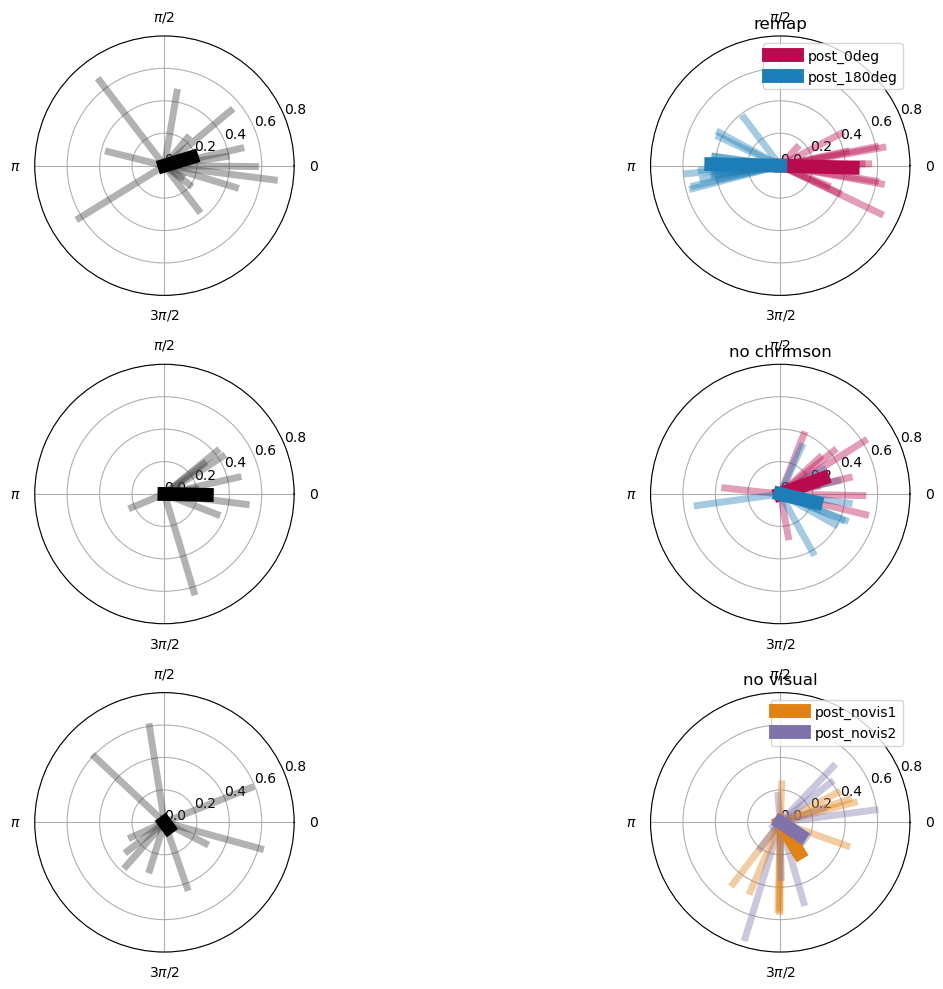

In [32]:
fig, ax = plt.subplots(3, 2, subplot_kw={'projection':'polar'}, figsize=[15,10])

for _, row in remap_sum_stats.iterrows():
    ax[0,0].plot(row['baseline mean offset']*np.ones([2,]), [0, row['baseline vec. len']], color=plt.cm.Greys(.8), alpha=.4, linewidth=5)
    
    ax[0,1].plot(row['post_0deg mean offset']*np.ones([2,]), [0, row['post_0deg vec. len']], color=plt.cm.PuRd(.8), alpha=.4, linewidth=5)
    ax[0,1].plot(row['post_180deg mean offset']*np.ones([2,]), [0, row['post_180deg vec. len']], color=plt.cm.GnBu(.8), alpha=.4, linewidth=5)

baseline_v = remap_sum_stats['baseline vec. len']*(np.cos(remap_sum_stats['baseline mean offset'])+1j*np.sin(remap_sum_stats['baseline mean offset']))
ax[0,0].plot(np.angle(baseline_v.mean())*np.ones((2,)), np.absolute(baseline_v.mean())*np.array([0,1]), color='black', linewidth=10)

post_0deg_v = remap_sum_stats['post_0deg vec. len']*(np.cos(remap_sum_stats['post_0deg mean offset'])+1j*np.sin(remap_sum_stats['post_0deg mean offset']))
ax[0,1].plot(np.angle(post_0deg_v.mean())*np.ones((2,)), np.absolute(post_0deg_v.mean())*np.array([0,1]), 
             color=plt.cm.PuRd(.8), linewidth=10, label='post_0deg')

post_180deg_v = remap_sum_stats['post_180deg vec. len']*(np.cos(remap_sum_stats['post_180deg mean offset'])+1j*np.sin(remap_sum_stats['post_180deg mean offset']))
ax[0,1].plot(np.angle(post_180deg_v.mean())*np.ones((2,)), np.absolute(post_180deg_v.mean())*np.array([0,1]), 
             color=plt.cm.GnBu(.8), linewidth=10, label='post_180deg')

ax[0,1].legend()


##
for _, row in nochrimson_sum_stats.iterrows():
    ax[1, 0].plot(row['baseline mean offset']*np.ones([2,]), [0, row['baseline vec. len']], color=plt.cm.Greys(.8), alpha=.4, linewidth=5)
    
    ax[1, 1].plot(row['post_0deg mean offset']*np.ones([2,]), [0, row['post_0deg vec. len']], color=plt.cm.PuRd(.8), alpha=.4, linewidth=5)
    ax[1, 1].plot(row['post_180deg mean offset']*np.ones([2,]), [0, row['post_180deg vec. len']], color=plt.cm.GnBu(.8), alpha=.4, linewidth=5)

baseline_v = nochrimson_sum_stats['baseline vec. len']*(np.cos(nochrimson_sum_stats['baseline mean offset'])+1j*np.sin(nochrimson_sum_stats['baseline mean offset']))
ax[1, 0].plot(np.angle(baseline_v.mean())*np.ones((2,)), np.absolute(baseline_v.mean())*np.array([0,1]), color='black', linewidth=10)

post_0deg_v = nochrimson_sum_stats['post_0deg vec. len']*(np.cos(nochrimson_sum_stats['post_0deg mean offset'])+1j*np.sin(nochrimson_sum_stats['post_0deg mean offset']))
ax[1,1].plot(np.angle(post_0deg_v.mean())*np.ones((2,)), np.absolute(post_0deg_v.mean())*np.array([0,1]), 
             color=plt.cm.PuRd(.8), linewidth=10, label='post_0deg')

post_180deg_v = nochrimson_sum_stats['post_180deg vec. len']*(np.cos(nochrimson_sum_stats['post_180deg mean offset'])+1j*np.sin(nochrimson_sum_stats['post_180deg mean offset']))
ax[1,1].plot(np.angle(post_180deg_v.mean())*np.ones((2,)), np.absolute(post_180deg_v.mean())*np.array([0,1]), 
             color=plt.cm.GnBu(.8), linewidth=10, label='post_180deg')


##
for _, row in novis_sum_stats.iterrows():
    ax[2, 0].plot(row['baseline mean offset']*np.ones([2,]), [0, row['baseline vec. len']], color=plt.cm.Greys(.8), alpha=.4, linewidth=5)
    
    ax[2, 1].plot(row['post_novis1 mean offset']*np.ones([2,]), [0, row['post_novis1 vec. len']], color=plt.cm.PuOr(.2), alpha=.4, linewidth=5)
    ax[2, 1].plot(row['post_novis2 mean offset']*np.ones([2,]), [0, row['post_novis2 vec. len']], color=plt.cm.PuOr(.8), alpha=.4, linewidth=5)

baseline_v = novis_sum_stats['baseline vec. len']*(np.cos(novis_sum_stats['baseline mean offset'])+1j*np.sin(novis_sum_stats['baseline mean offset']))
ax[2, 0].plot(np.angle(baseline_v.mean())*np.ones((2,)), np.absolute(baseline_v.mean())*np.array([0,1]), color='black', linewidth=10)

post_novis1_v = novis_sum_stats['post_novis1 vec. len']*(np.cos(novis_sum_stats['post_novis1 mean offset'])+1j*np.sin(novis_sum_stats['post_novis1 mean offset']))
ax[2,1].plot(np.angle(post_novis1_v.mean())*np.ones((2,)), np.absolute(post_novis1_v.mean())*np.array([0,1]), 
             color=plt.cm.PuOr(.2), linewidth=10, label='post_novis1')

post_novis2_v = novis_sum_stats['post_novis2 vec. len']*(np.cos(novis_sum_stats['post_novis2 mean offset'])+1j*np.sin(novis_sum_stats['post_novis2 mean offset']))
ax[2,1].plot(np.angle(post_novis2_v.mean())*np.ones((2,)), np.absolute(post_novis2_v.mean())*np.array([0,1]), 
             color=plt.cm.PuOr(.8), linewidth=10, label='post_novis2')

for a in ax.flatten():
    a.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2], ['0', r'$\pi$/2', r'$\pi$', r'3$\pi$/2'])
    a.set_yticks([0,.2,.4,.6, .8])
    a.set_ylim([0,.8])

ax[2,1].legend()

ax[0,1].set_title('remap')
ax[1,1].set_title('no chrimson')
ax[2,1].set_title('no visual')


fig.tight_layout()

fig.savefig(figfolder / "remapping_all_flies_polar.pdf")

In [33]:
novis_sum_stats.columns

Index(['fly_id', 'baseline mean offset', 'baseline vec. len',
       'baseline offset var.', 'post_novis1 mean offset',
       'post_novis1 vec. len', 'post_novis1 offset var.',
       'post_novis2 mean offset', 'post_novis2 vec. len',
       'post_novis2 offset var.'],
      dtype='object')

In [34]:
remap_sum_stats

fly_id  baseline mean offset  baseline vec. len  \
0   11_07_2024_fly1_remap             -0.297471           0.458384   
1   15_07_2024_fly1_remap             -0.647330           0.193653   
2   18_07_2024_fly1_remap              0.223111           0.482829   
3   18_07_2024_fly2_remap              0.692647           0.529232   
4   18_07_2024_fly3_remap             -2.589927           0.617202   
5   01_08_2024_fly2_remap             -0.918561           0.345713   
6   01_08_2024_fly3_remap              2.898085           0.356221   
7   01_08_2024_fly4_remap              0.145027           0.385728   
8   01_08_2024_fly5_remap              2.222797           0.657611   
9   02_08_2024_fly2_remap              0.878965           0.221272   
10  02_08_2024_fly4_remap             -0.566025           0.124160   
11  02_08_2024_fly6_remap             -0.129290           0.683220   
12  05_08_2024_fly2_remap             -0.009657           0.560593   
13  26_08_2024_fly1_remap              1.403451           0.459081   

    baseline offset var.  post_0deg mean offset  post_0deg vec. len  \
0               0.541616              -0.160008            0.595068   
1               0.806347              -0.057459            0.411714   
2               0.517171               0.195338            0.598303   
3               0.470768               0.020037            0.545128   
4               0.382798              -0.447636            0.684617   
5               0.654287               0.825834            0.149907   
6               0.643779              -0.178204            0.633545   
7               0.614272              -0.436990            0.393782   
8               0.342389               0.175409            0.642239   
9               0.778728               0.487402            0.422656   
10              0.875840              -0.397711            0.314574   
11              0.316780               0.023221            0.504228   
12              0.439407              -0.031063            0.217276   
13              0.540919               0.213416            0.415081   

    post_0deg offset var.  post_180deg mean offset  post_180deg vec. len  \
0                0.404932                -3.007451              0.373136   
1                0.588286                 3.004484              0.407184   
2                0.401697                -3.081782              0.488026   
3                0.454872                -2.971829              0.484066   
4                0.315383                -2.912882              0.545727   
5                0.850093                -2.927840              0.389178   
6                0.366455                 2.643864              0.427886   
7                0.606218                 2.702549              0.416709   
8                0.357761                 2.999817              0.406430   
9                0.577344                -3.002291              0.414484   
10               0.685426                 2.220169              0.370469   
11               0.495772                -2.884718              0.559045   
12               0.782724                -3.020052              0.404158   
13               0.584919                -3.056591              0.577605   

    post_180deg offset var.  
0                  0.626864  
1                  0.592816  
2                  0.511974  
3                  0.515934  
4                  0.454273  
5                  0.610822  
6                  0.572114  
7                  0.583291  
8                  0.593570  
9                  0.585516  
10                 0.629531  
11                 0.440955  
12                 0.595842  
13                 0.422395

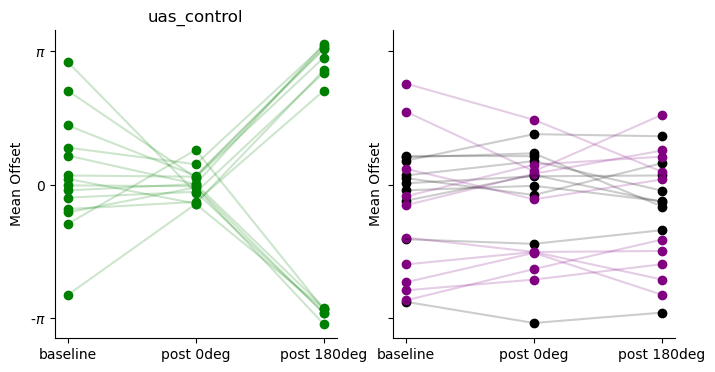

In [35]:
fig, ax = plt.subplots(1,2, figsize=[8,4], sharex=True, sharey=True)
nmp.remapping.plot_min_dist(remap_sum_stats, ax[0], color='green')
ax[0].set_title('uas_control')
nmp.remapping.plot_min_dist(nochrimson_sum_stats, ax[1], color='black', zero=True)
nmp.remapping.plot_min_dist(novis_sum_stats, ax[1], color='purple', zero=True)


# ax[1].set_title('')

for a in ax.flatten():
    a.set_xticks([0,1,2], ['baseline', 'post 0deg', 'post 180deg'])
    a.set_yticks([-np.pi,0,np.pi], [r'-$\pi$', '0', r'$\pi$'])
    a.set_ylabel('Mean Offset')
    
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)

fig.savefig(figfolder / "remapping_all_flies.pdf")

In [36]:
def avg_diff(sum_stats):
    if not 'post_novis1 mean offset' in sum_stats.columns:
        diff0 = np.abs(sum_stats['post_0deg mean offset'] )
        diff180 = np.abs(np.pi - sum_stats['post_180deg mean offset'] )
        diff180 = np.minimum(diff180, 2*np.pi-diff180)
        
        
        
    else:
        diff0 = np.abs(sum_stats['post_novis1 mean offset'])
        diff0 = np.minimum(diff0, 2*np.pi-diff0)
        
        diff180 = np.abs(np.pi - sum_stats['post_novis2 mean offset'] )
        diff180 = np.minimum(diff180, 2*np.pi-diff180)
                
    return (diff0+diff180)/2

In [37]:
novis_sum_stats.columns

Index(['fly_id', 'baseline mean offset', 'baseline vec. len',
       'baseline offset var.', 'post_novis1 mean offset',
       'post_novis1 vec. len', 'post_novis1 offset var.',
       'post_novis2 mean offset', 'post_novis2 vec. len',
       'post_novis2 offset var.'],
      dtype='object')

remap error less than chance: t=0.0, p=0.0001220703125
no chrimson error less than chance: t=19.0, p=0.734375
no visual error less than chance: t=24.0, p=0.76953125
remap diff than no chrimson: t=0.0, p=8.246196397155047e-05
remap diff than no visual: t=0.0, p=4.711347153516133e-05


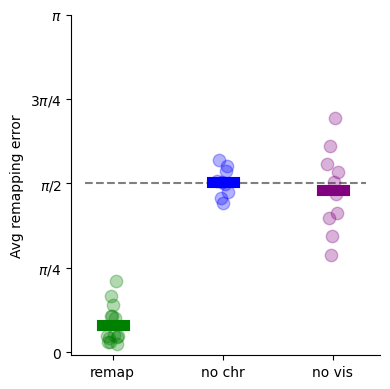

In [38]:
fig, ax = plt.subplots(figsize=[4,4])

remap_avg_diff = avg_diff(remap_sum_stats)
n_remap = remap_avg_diff.shape[0]
ax.scatter(np.linspace(0,.1,num=n_remap), remap_avg_diff, color='green', alpha=.3, s=80)
ax.plot([-.05,.15], remap_avg_diff.mean()*np.ones([2,]), color='green', linewidth=8)

nochrimson_avg_diff = avg_diff(nochrimson_sum_stats)
n_nochrimson = nochrimson_avg_diff.shape[0]
ax.scatter(np.linspace(0,.1,num=n_nochrimson)+1, nochrimson_avg_diff, color='blue', alpha=.3, s=80)
ax.plot([.95,1.15], nochrimson_avg_diff.mean()*np.ones([2,]), color='blue', linewidth=8)

novis_avg_diff = avg_diff(novis_sum_stats)
n_novis = novis_avg_diff.shape[0]
ax.scatter(np.linspace(0,.1,num=n_novis)+2, novis_avg_diff, color='purple', alpha=.3, s=80)
ax.plot([1.95,2.15], novis_avg_diff.mean()*np.ones([2,]), color='purple', linewidth=8)





ax.plot([-.2,2.35], [np.pi/2, np.pi/2], 'k--', alpha=.5, zorder=-1)

ax.set_xticks([.05,1.05, 2.05], labels=['remap', 'no chr', 'no vis'])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('Avg remapping error')
_ = ax.set_yticks([0,np.pi/4,np.pi/2,3*np.pi/4, np.pi], labels=[0, r"$\pi$/4", r"$\pi$/2", r"$3\pi$/4", r"$\pi$"])

fig.tight_layout()


t, p = sp.stats.wilcoxon(remap_avg_diff - np.pi/2)
print(f"remap error less than chance: t={t}, p={p}")

nochrimson_avg_diff = nochrimson_avg_diff[~np.isnan(nochrimson_avg_diff)]
t, p = sp.stats.wilcoxon(nochrimson_avg_diff - np.pi/2)
print(f"no chrimson error less than chance: t={t}, p={p}")

t, p = sp.stats.wilcoxon(novis_avg_diff - np.pi/2)
print(f"no visual error less than chance: t={t}, p={p}")


t, p = sp.stats.mannwhitneyu(remap_avg_diff, nochrimson_avg_diff)
print(f"remap diff than no chrimson: t={t}, p={p}")

t, p = sp.stats.mannwhitneyu(remap_avg_diff, novis_avg_diff)
print(f"remap diff than no visual: t={t}, p={p}")


fig.savefig(figfolder / "remapping_error.pdf")

/home/mplitt/repos/NeuromodPlasticity/NeuromodPlasticity/remapping.py:143: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig_polar, ax_polar = plt.subplots(subplot_kw={'projection':'polar'})


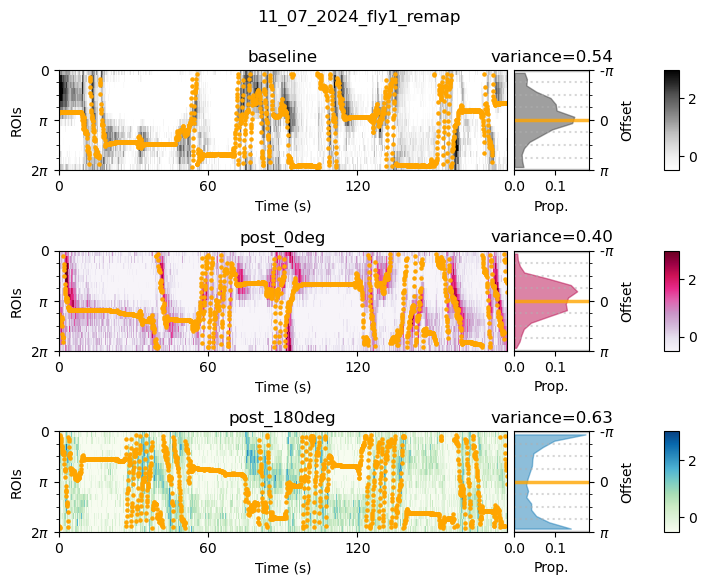

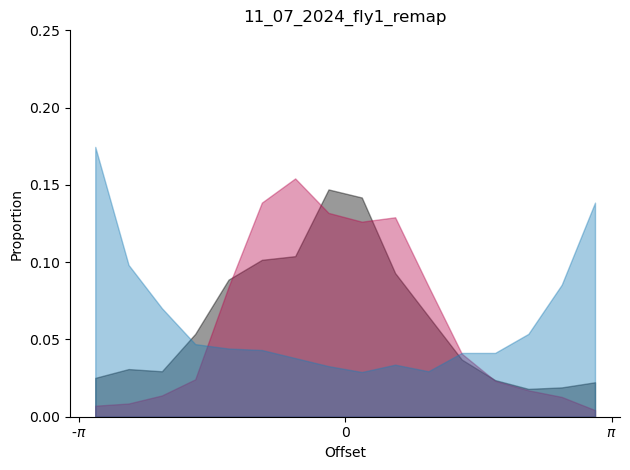

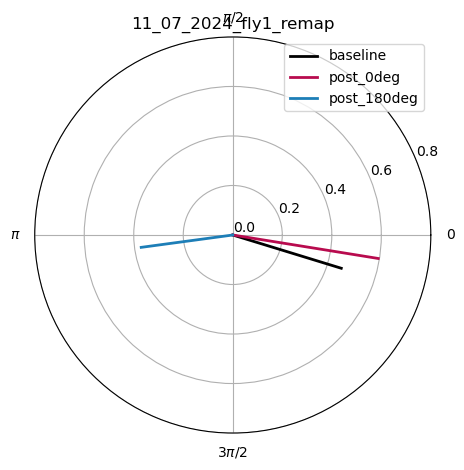

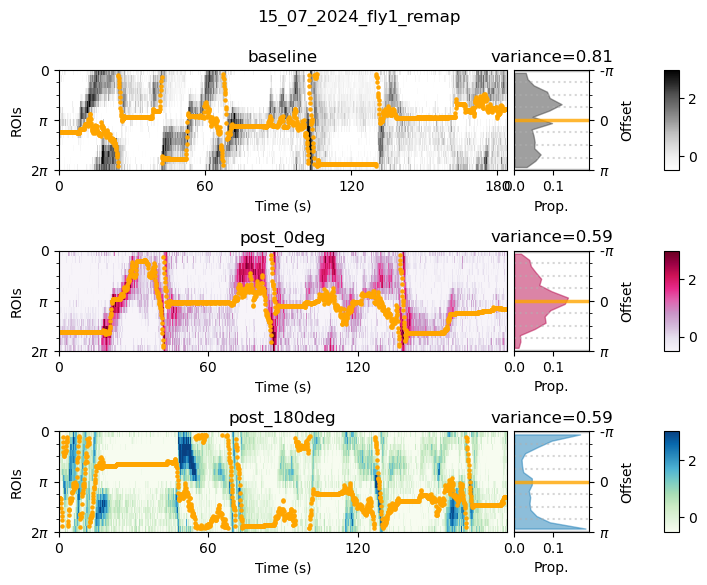

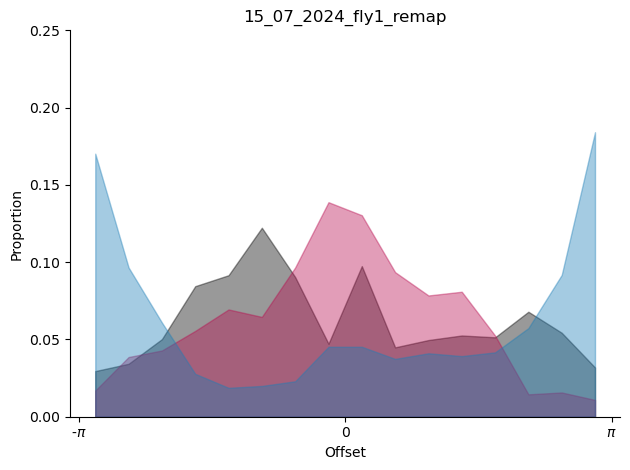

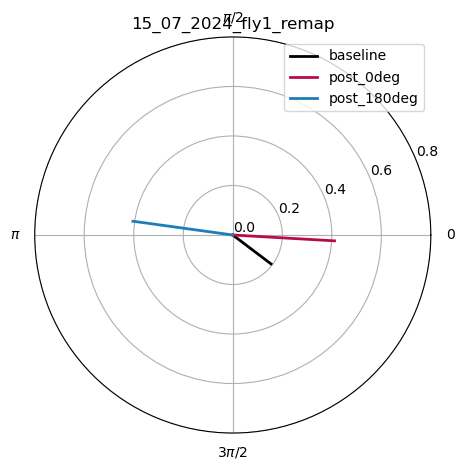

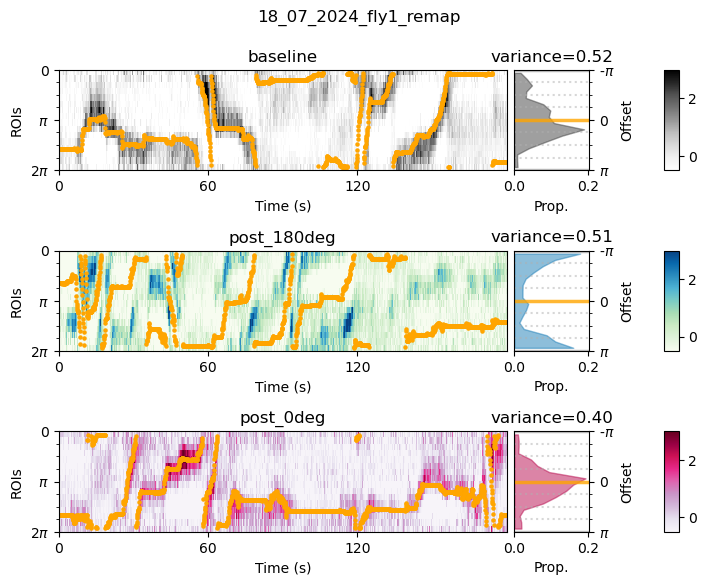

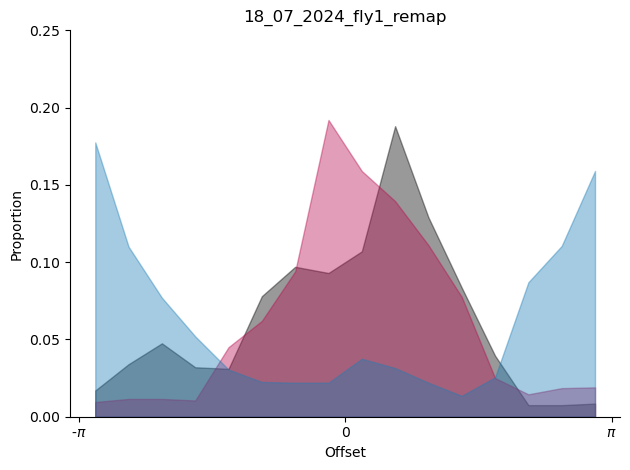

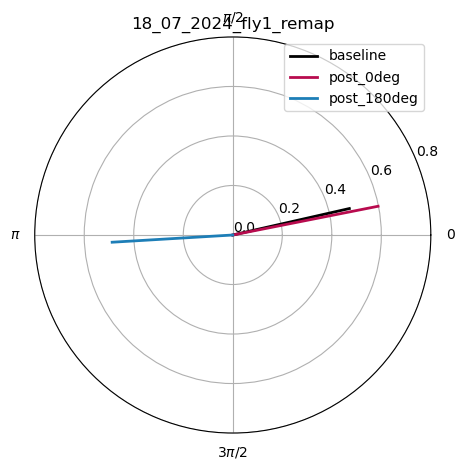

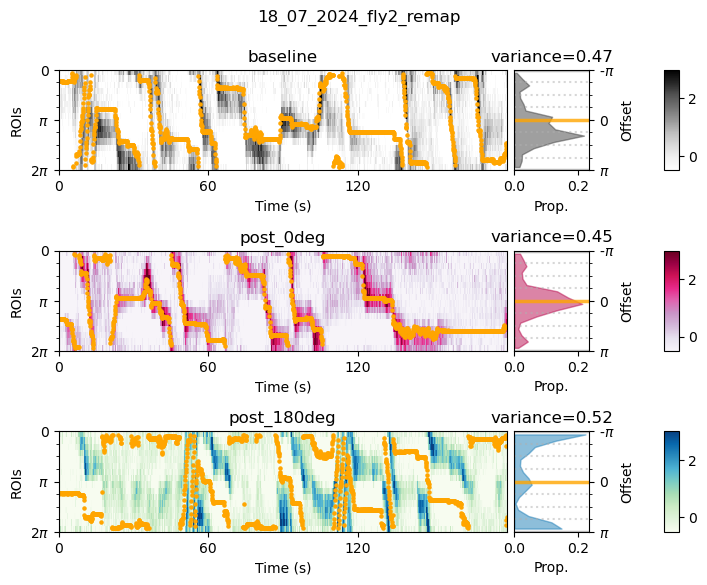

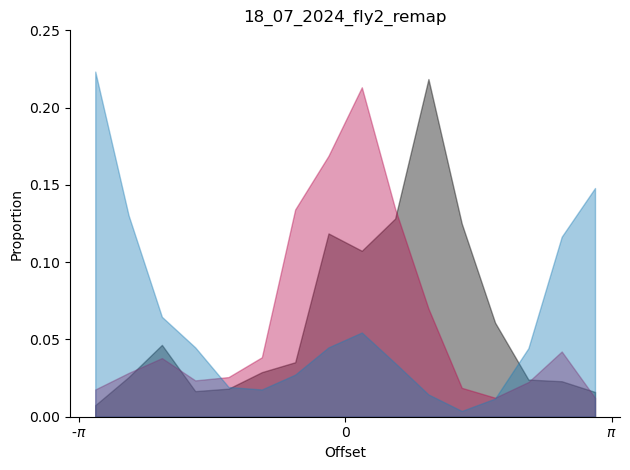

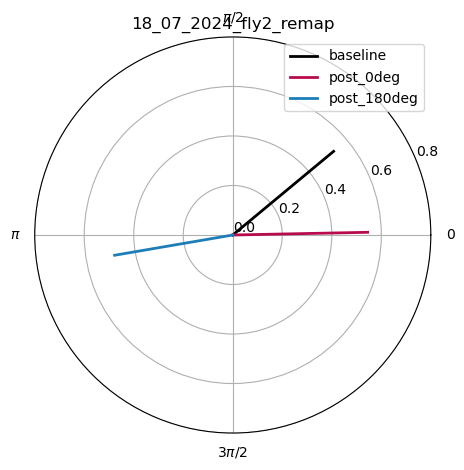

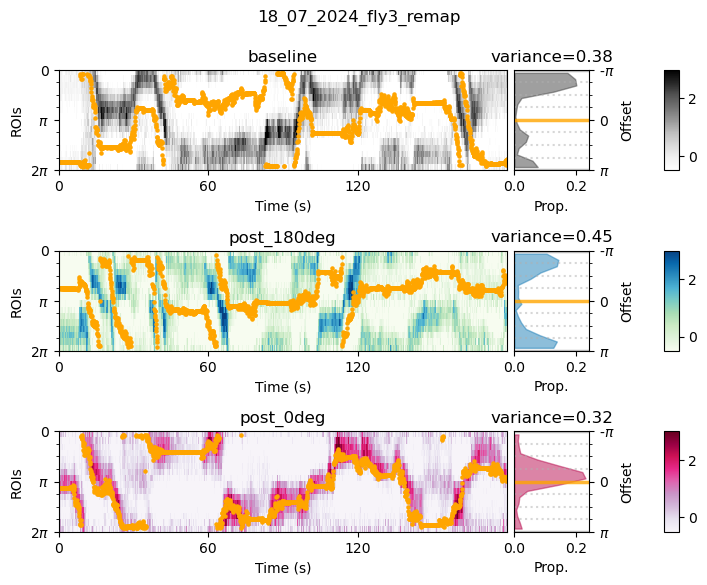

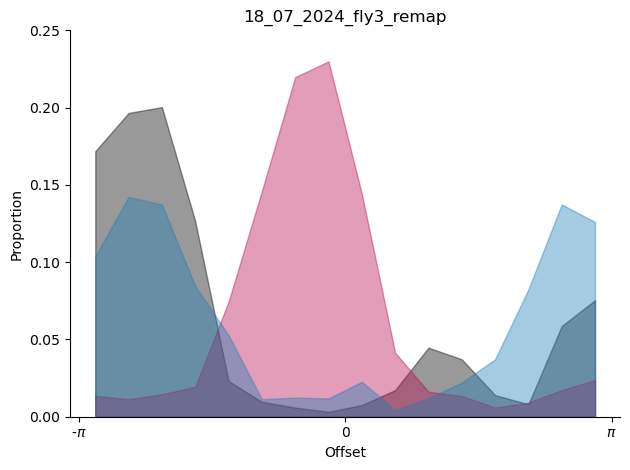

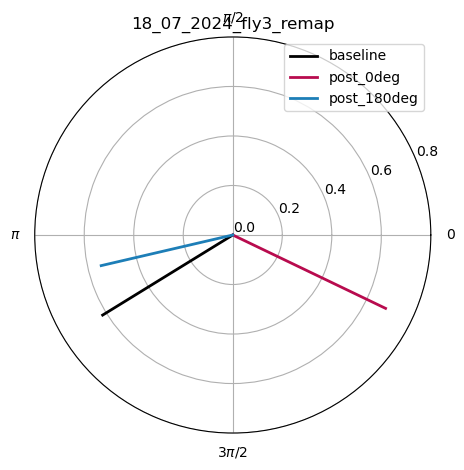

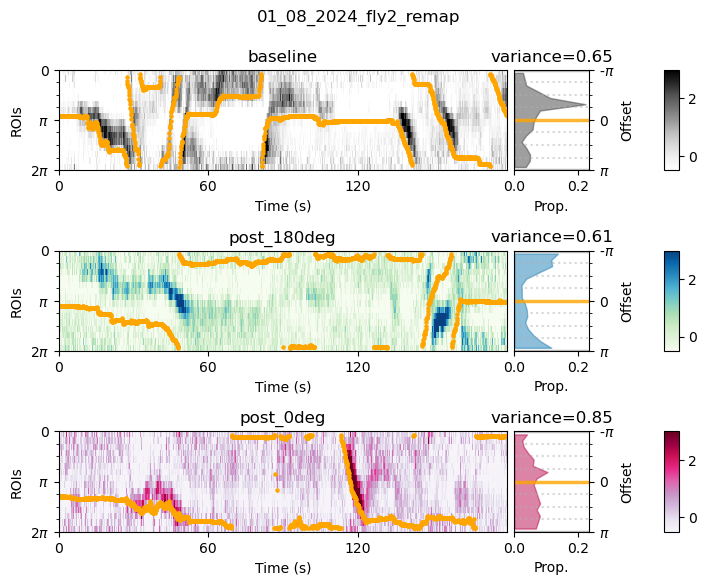

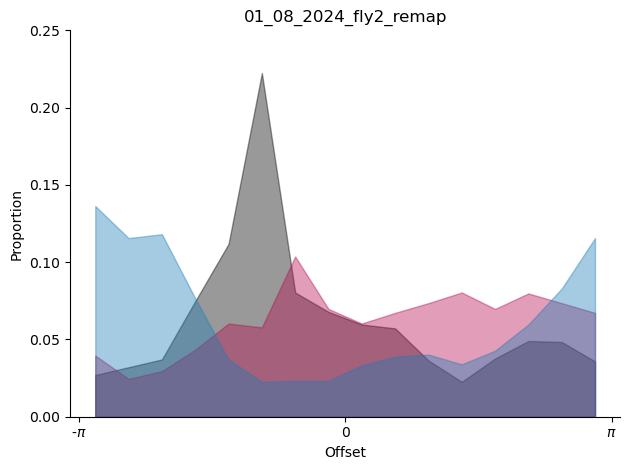

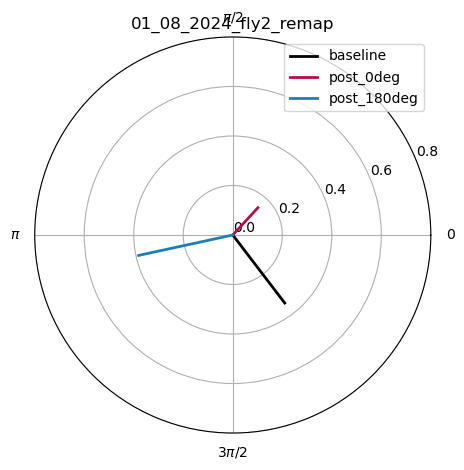

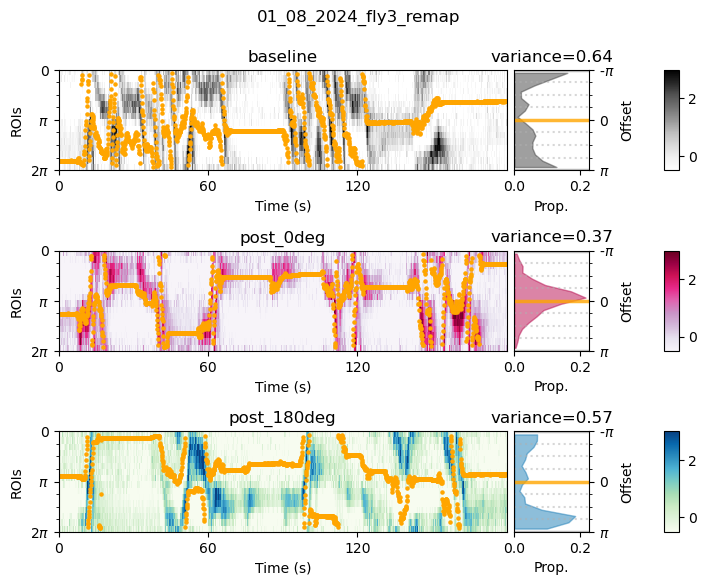

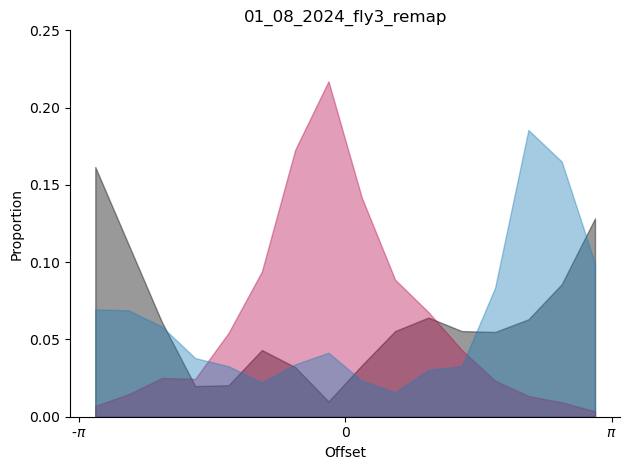

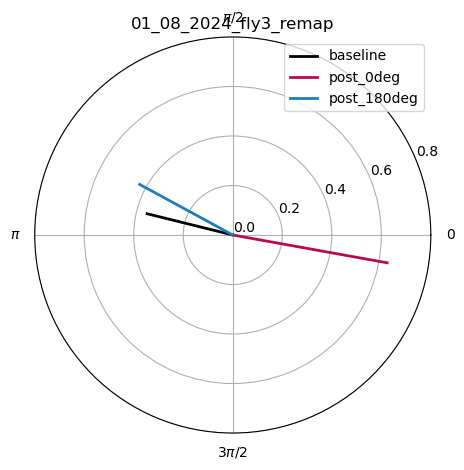

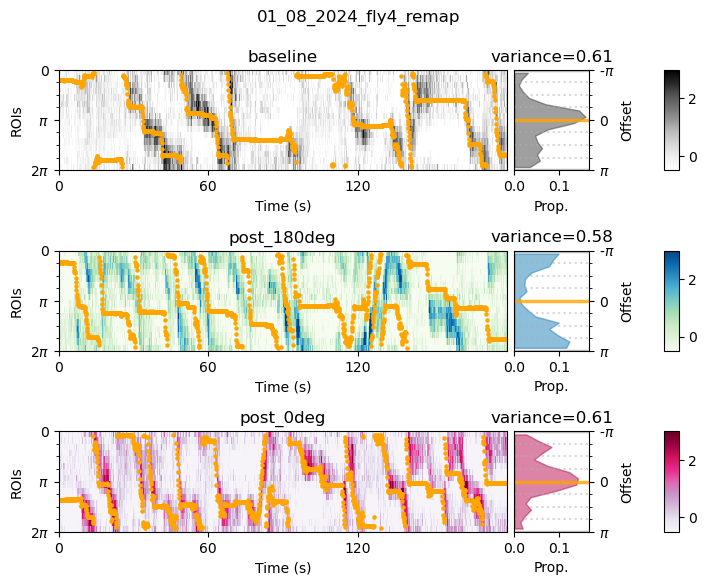

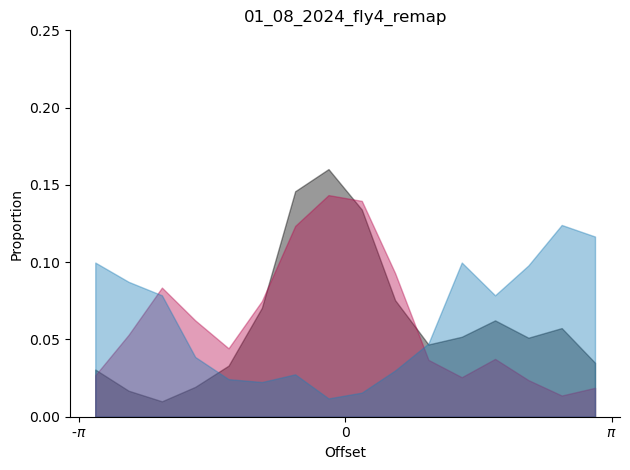

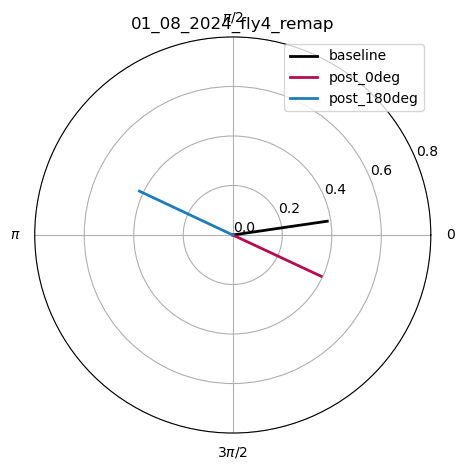

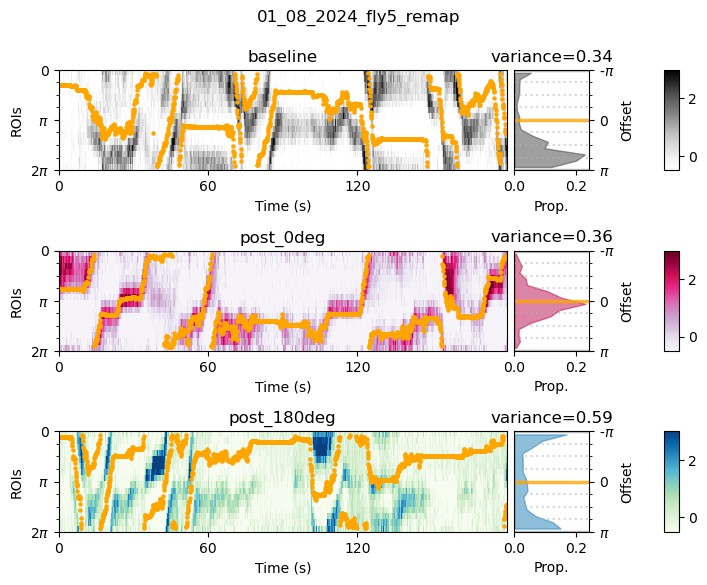

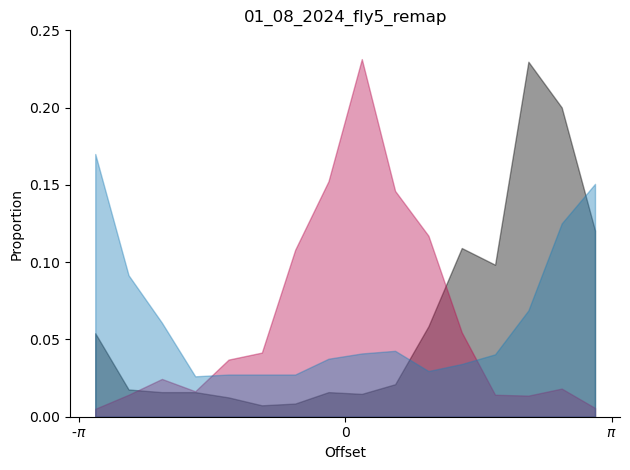

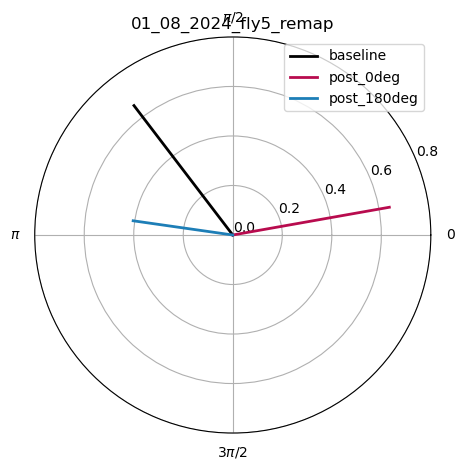

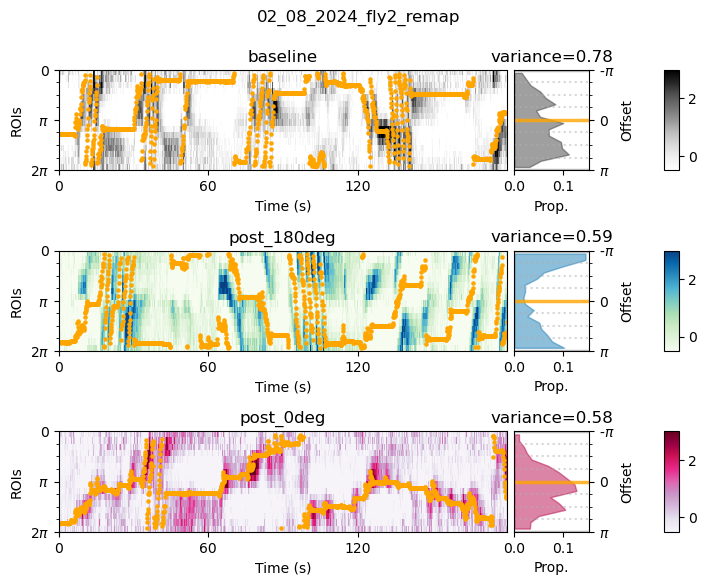

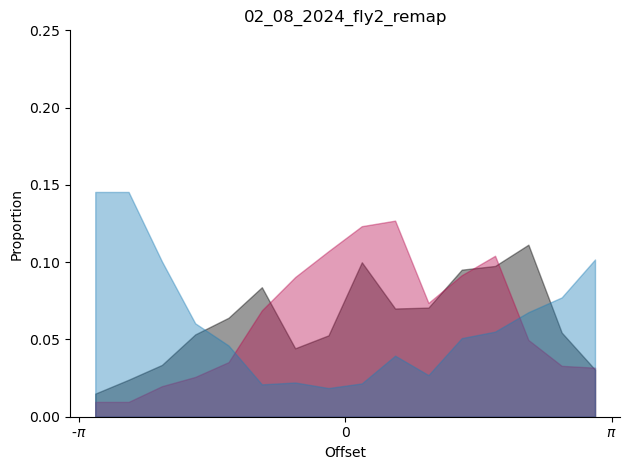

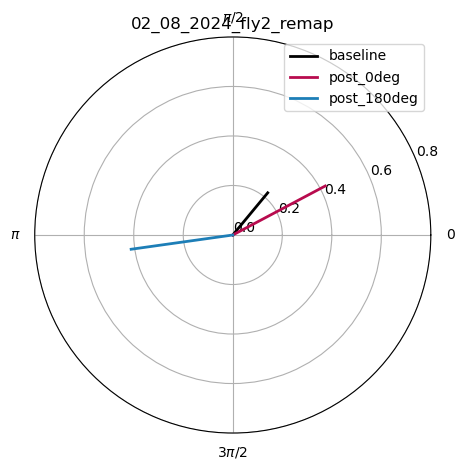

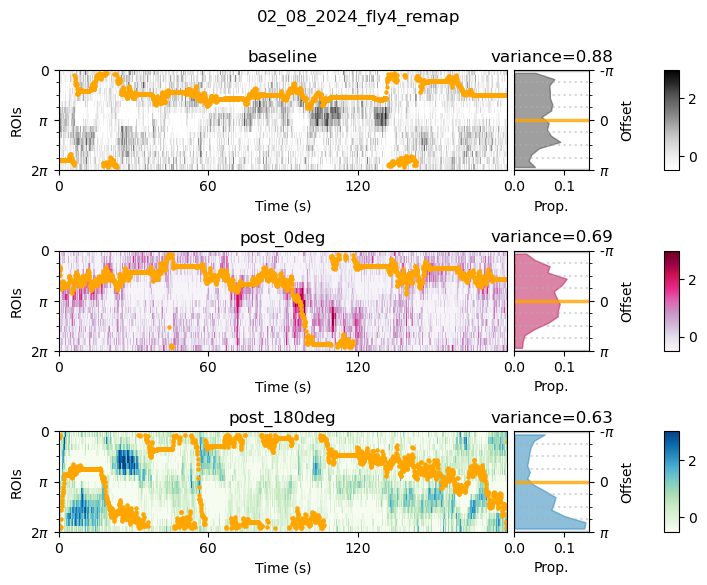

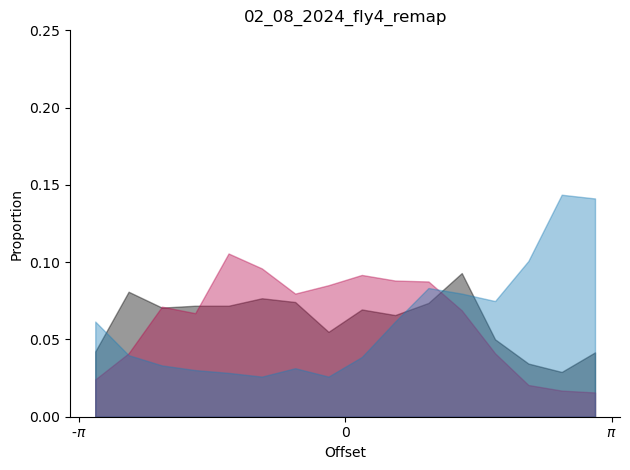

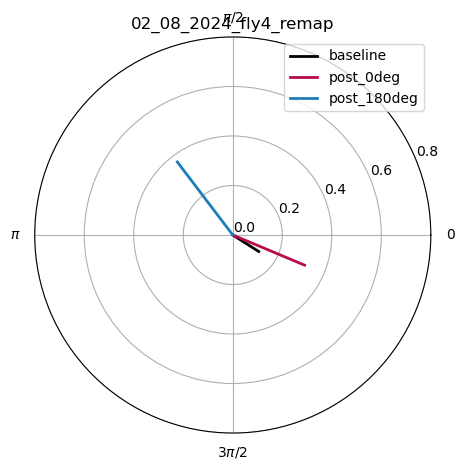

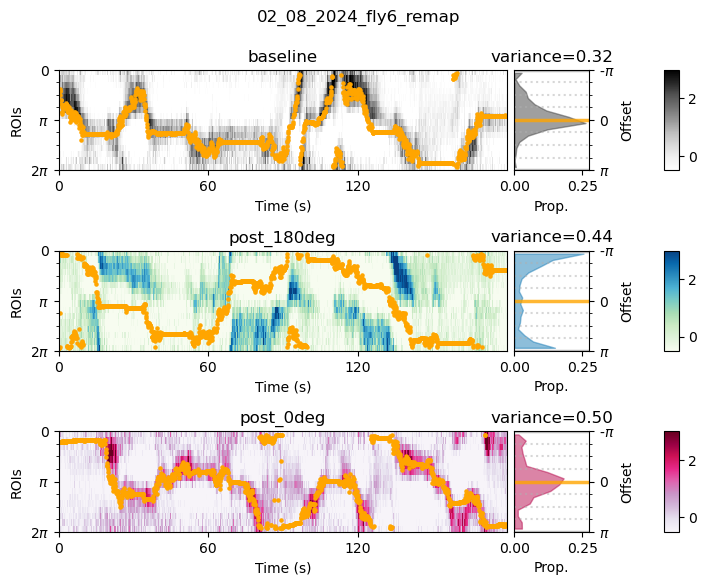

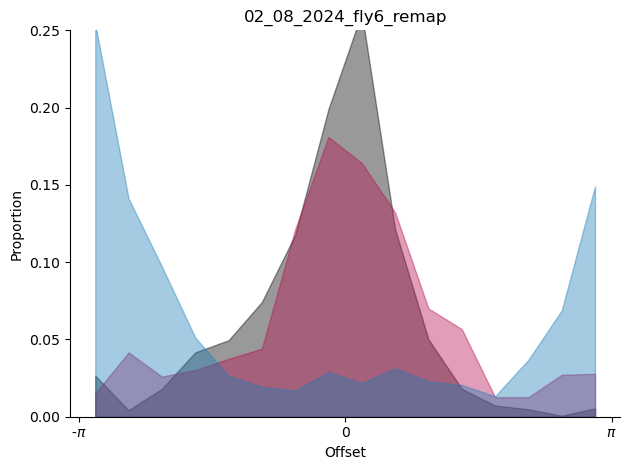

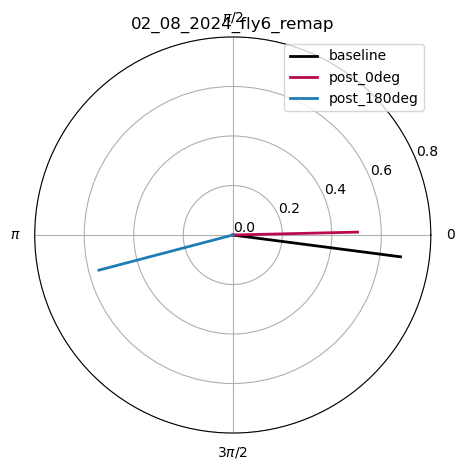

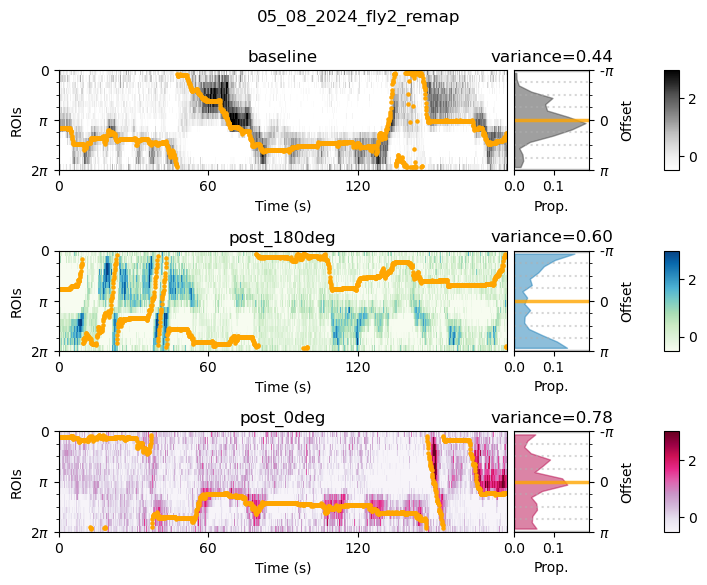

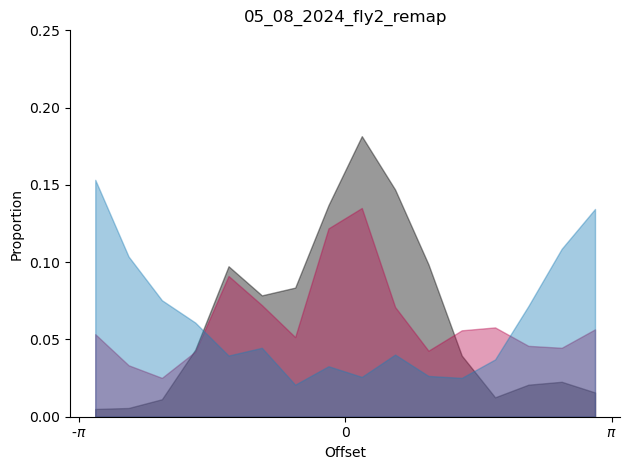

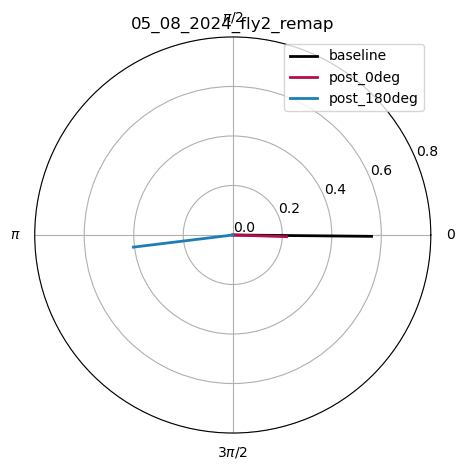

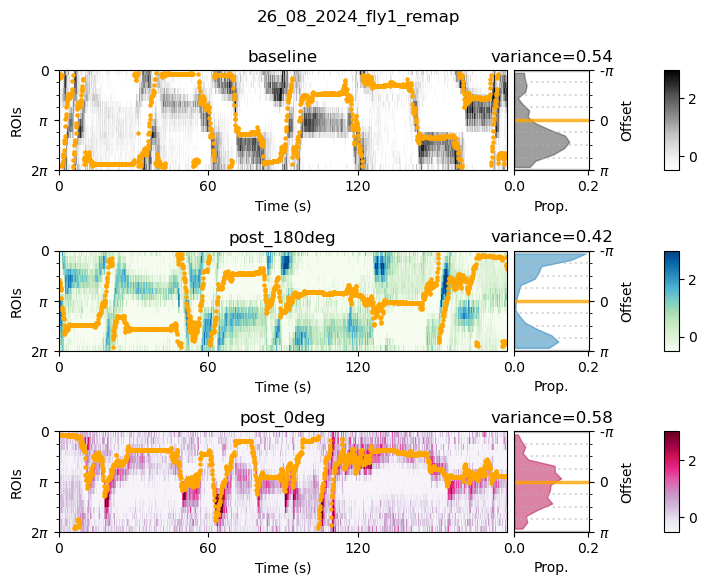

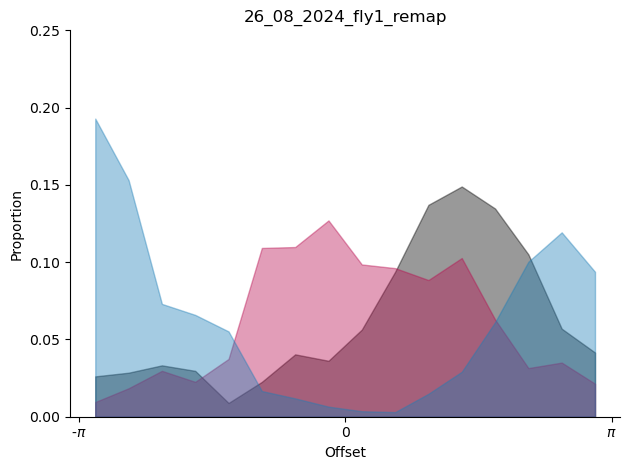

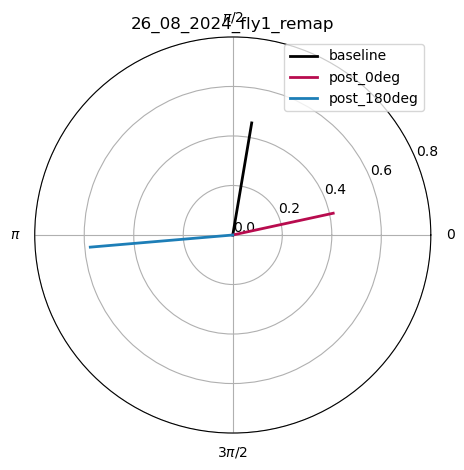

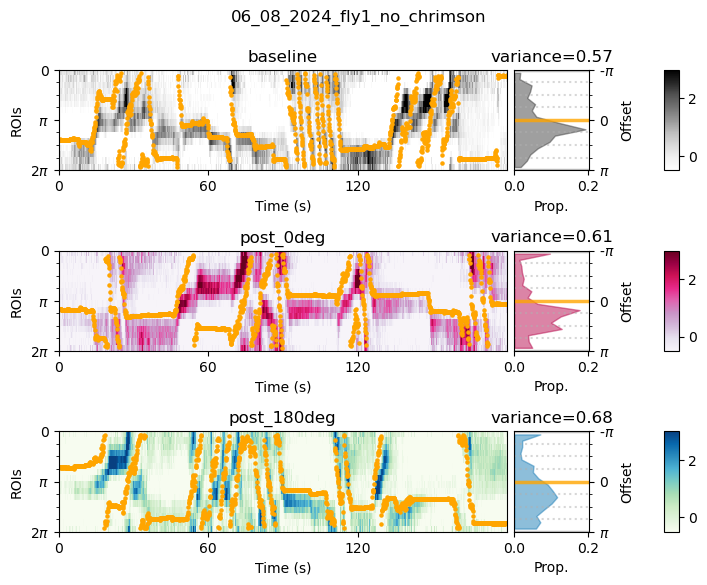

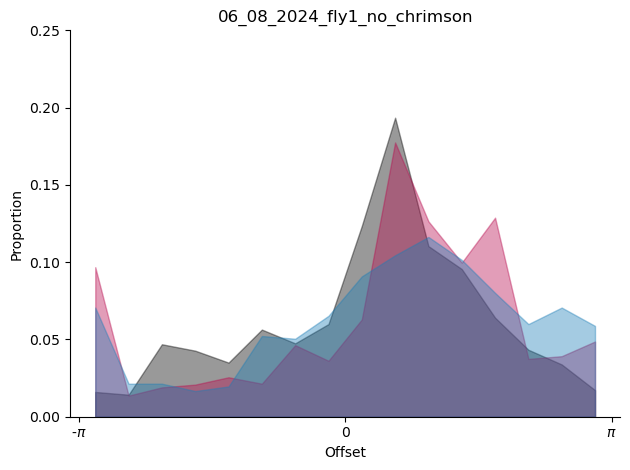

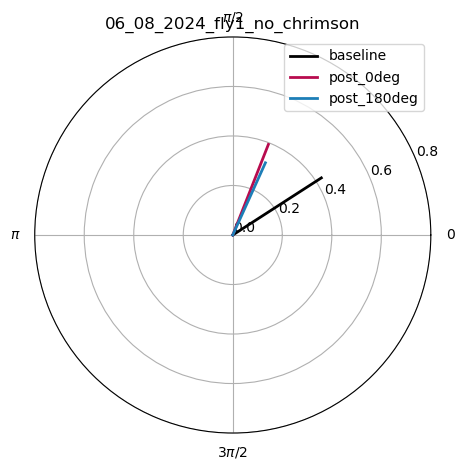

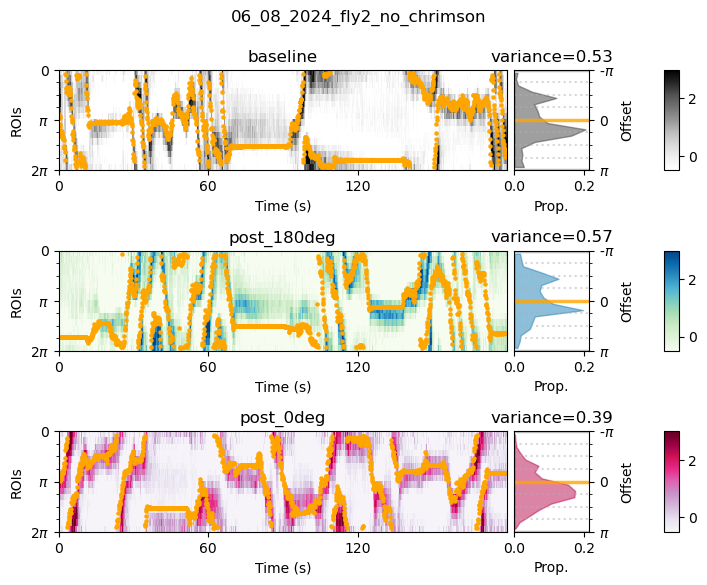

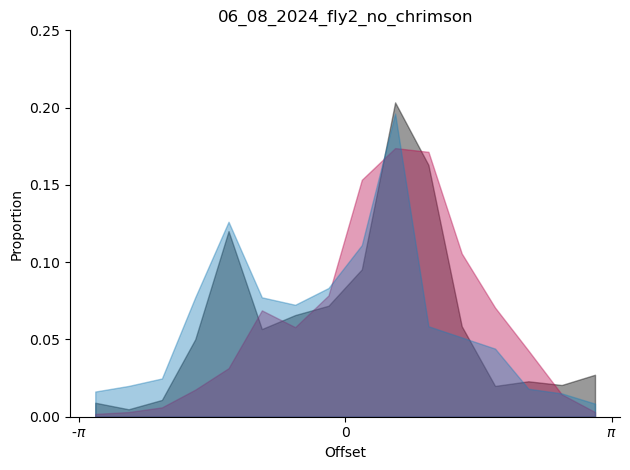

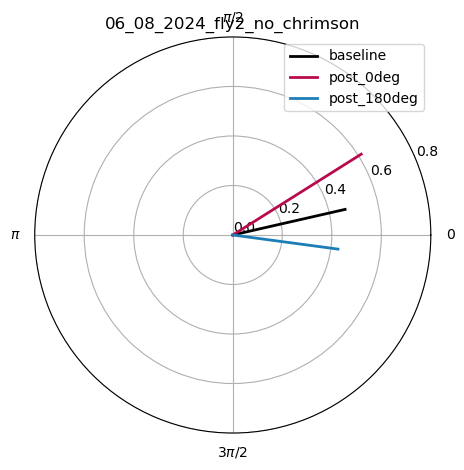

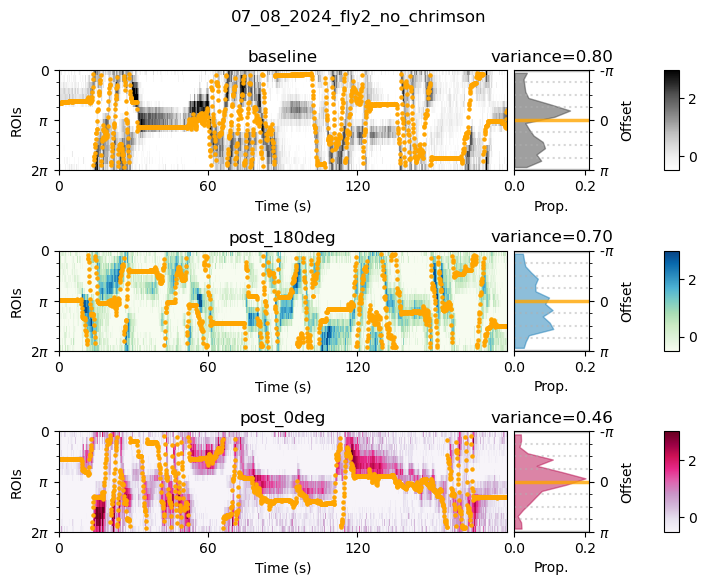

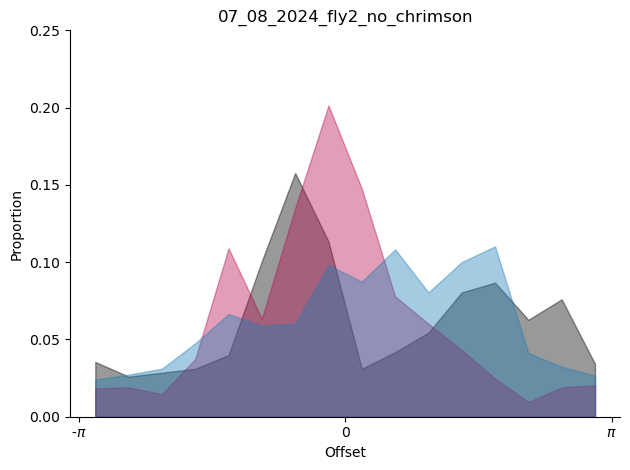

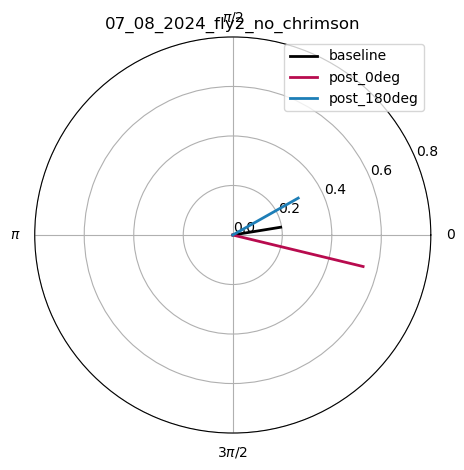

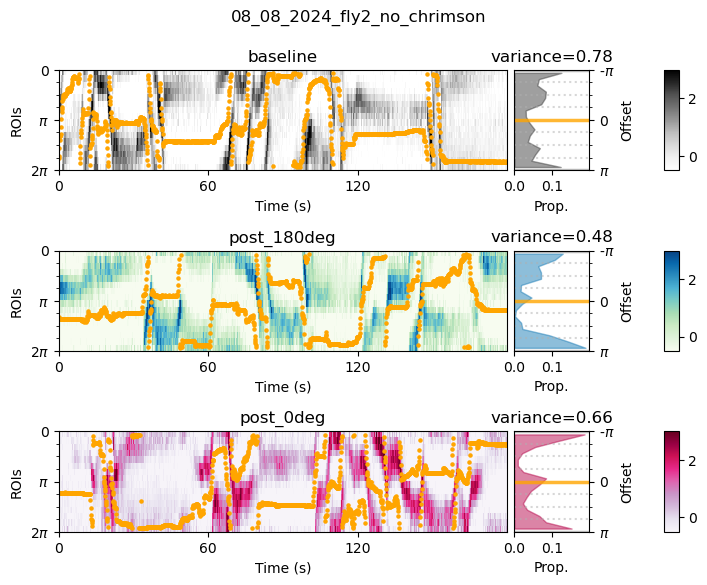

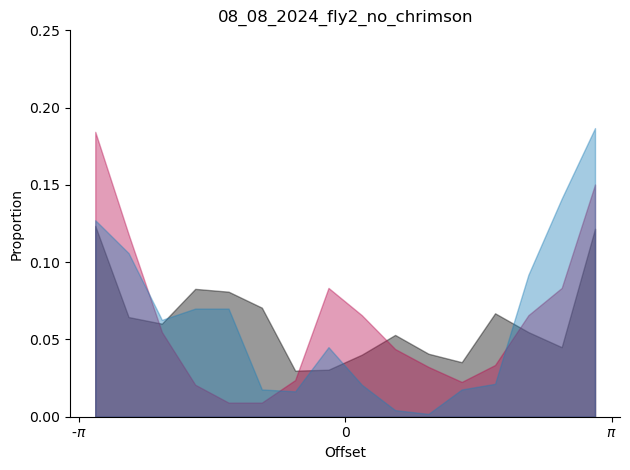

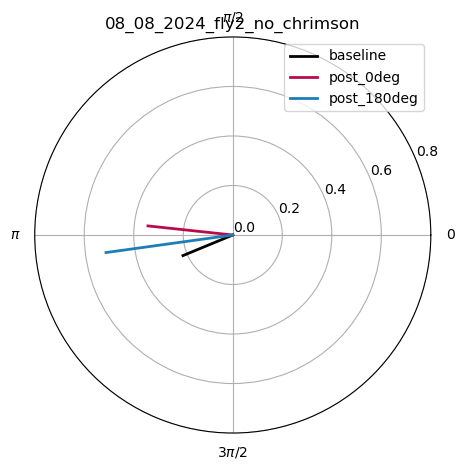

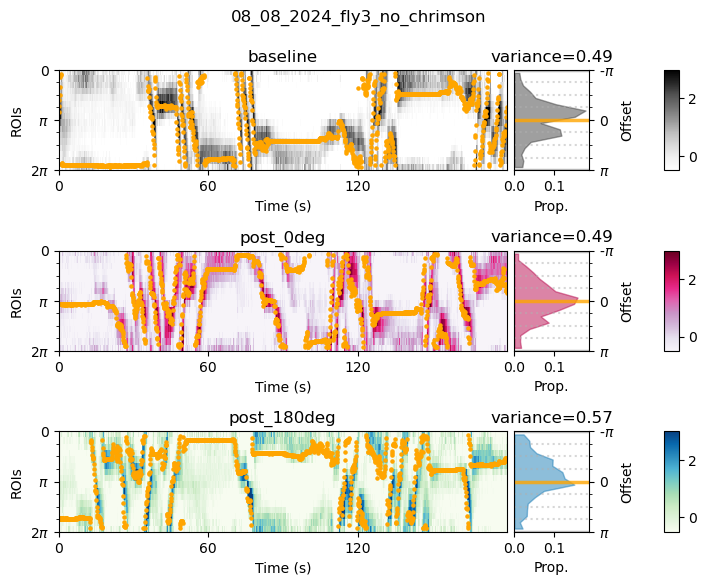

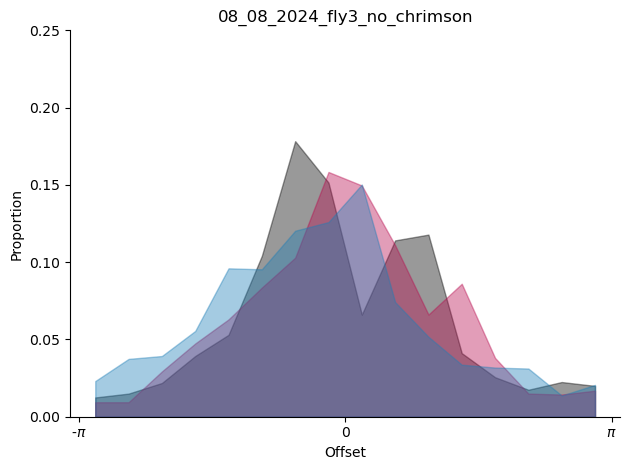

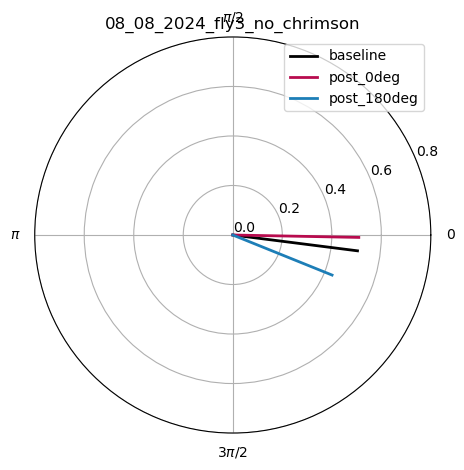

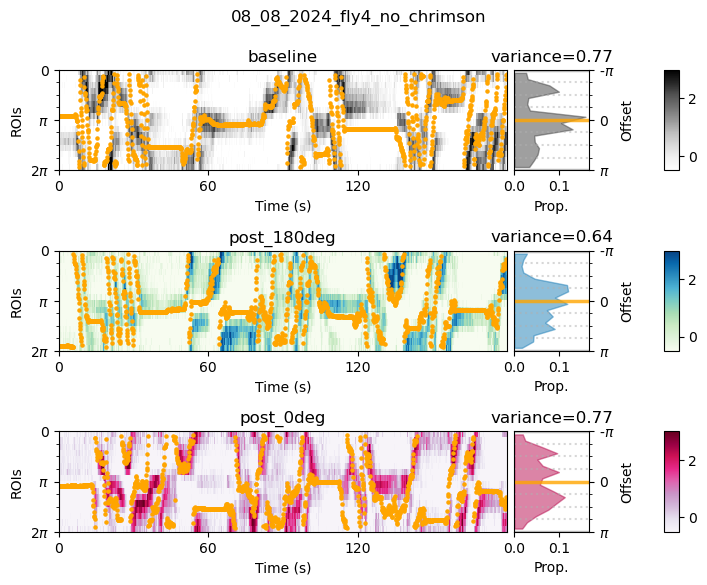

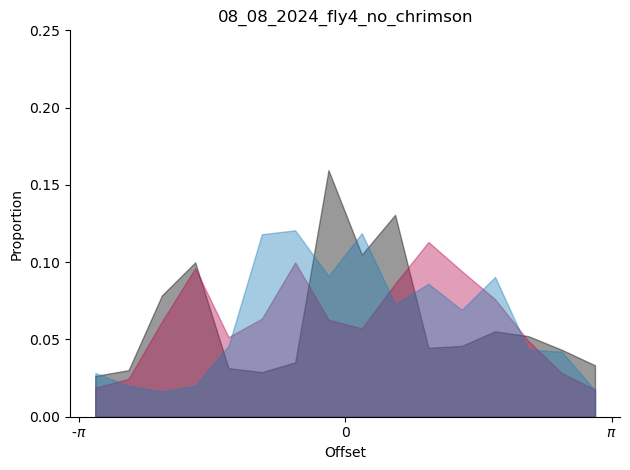

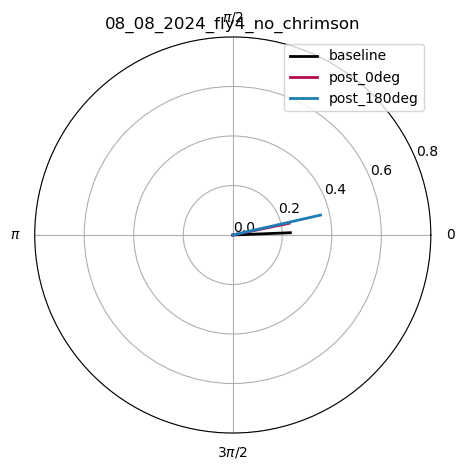

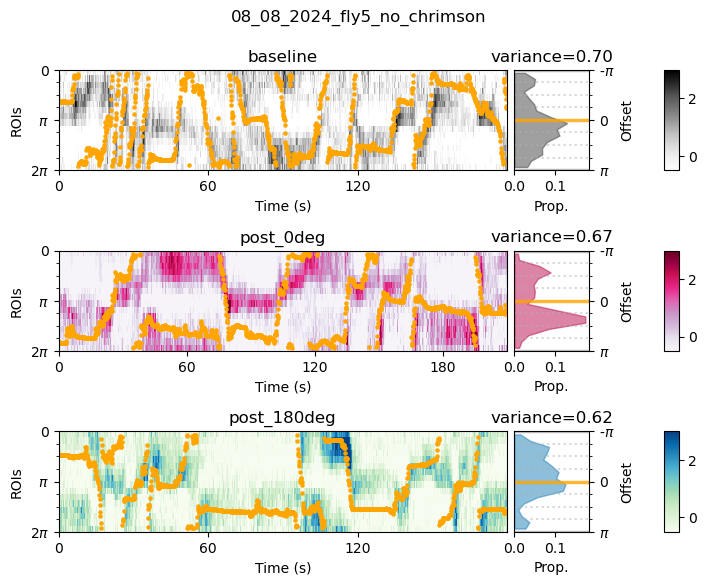

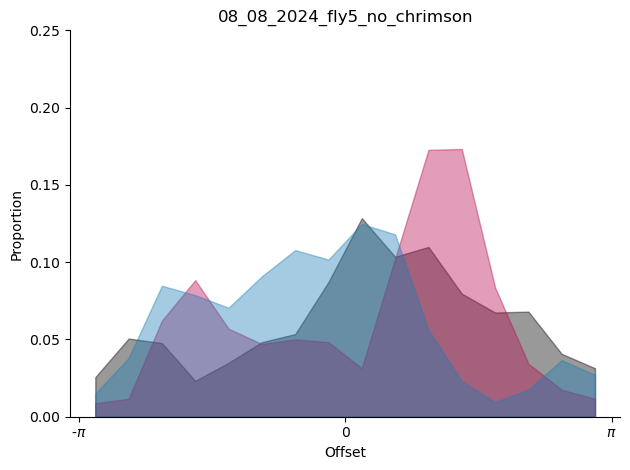

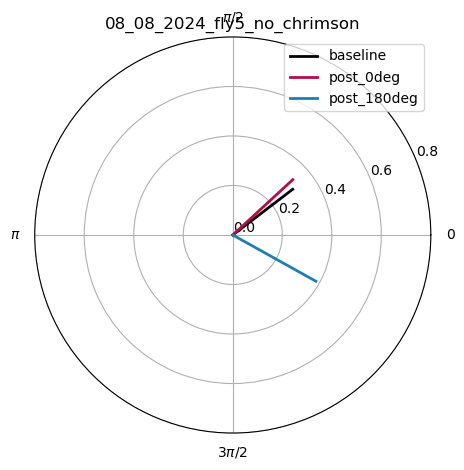

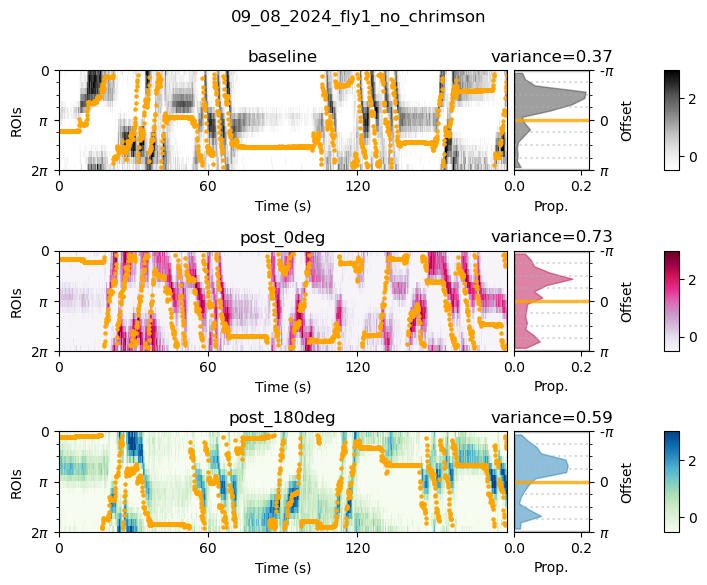

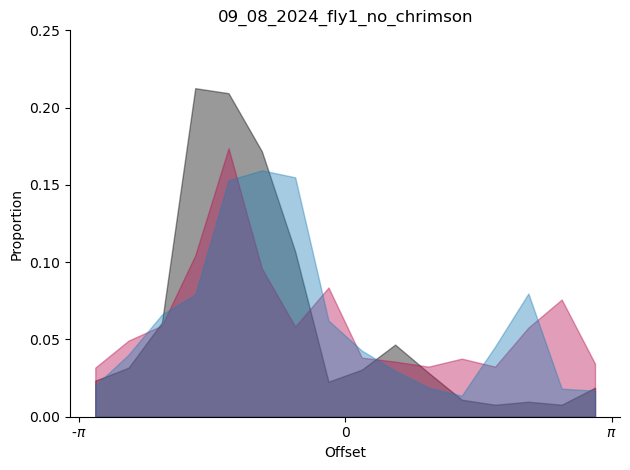

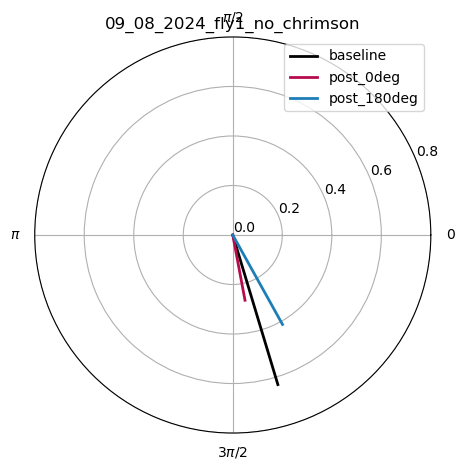

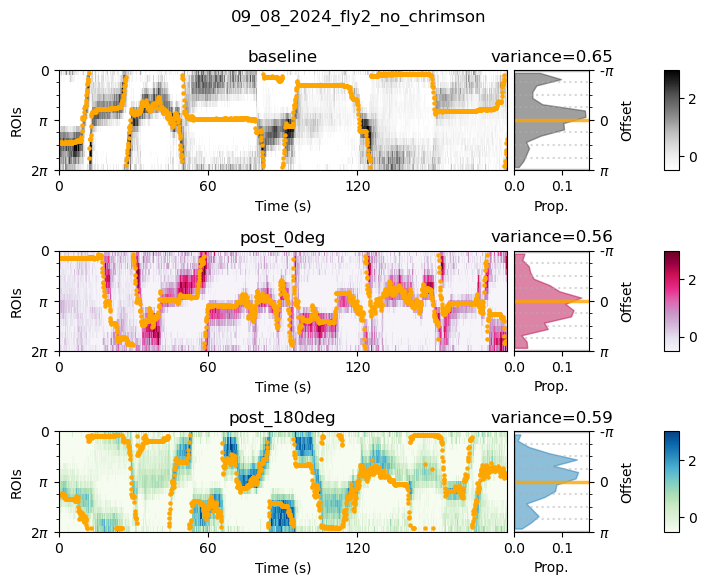

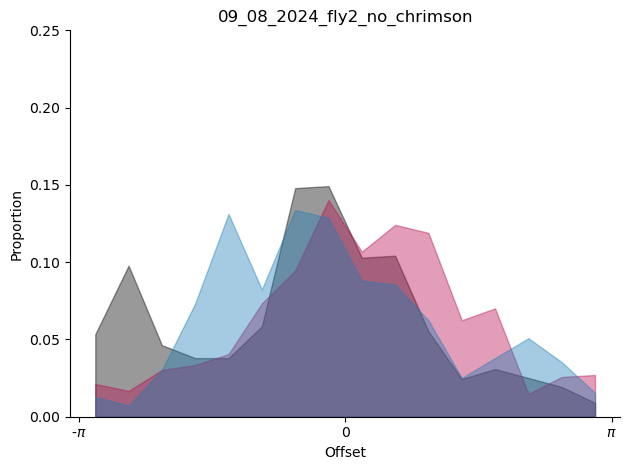

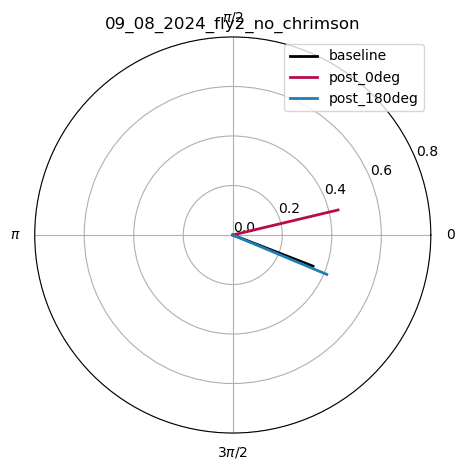

In [39]:
session_folder = figfolder / "sessions"
session_folder.mkdir(parents=True, exist_ok=True)

for fly in remap_flies + nochrimson_flies:

    baseline = sess_df.loc[(sess_df['fly_id']==fly) & (sess_df['scan_type']=='baseline')]
    post_0deg = sess_df.loc[(sess_df['fly_id']==fly) & (sess_df['scan_type']=='post_0deg')]
    post_180deg = sess_df.loc[(sess_df['fly_id']==fly) & (sess_df['scan_type']=='post_180deg')]
    
    if baseline.shape[0]>0 and post_0deg.shape[0]>0 and post_180deg.shape[0]>0:

        ts_dict = {'fly': fly,
                'baseline': nmp.session.GetTS(load_row(baseline.iloc[0])),
                'post_0deg': nmp.session.GetTS(load_row(post_0deg.iloc[0])),
                'post_180deg': nmp.session.GetTS(load_row(post_180deg.iloc[0]))}
        
        sess_inds = (
            int(baseline.iloc[0]['sess'][-3:]), 
            int(post_0deg.iloc[0]['sess'][-3:]), 
            int(post_180deg.iloc[0]['sess'][-3:]), 
        )
        sess_order = np.argsort(sess_inds)

        # fig_heatmaps, ax_heatmaps = nmp.remapping.plot_sess_heatmaps(ts_dict)
        fig_heatmaps, ax_heatmaps = nmp.remapping.plot_sess_heatmaps_w_hist(ts_dict, sess_order=sess_order)
        (fig_hist, ax_hist), (fig_polar, ax_polar) = nmp.remapping.plot_sess_histograms(ts_dict)

        
        fly_folder = session_folder / fly
        fly_folder.mkdir(parents=True, exist_ok=True)
        
        fig_heatmaps.savefig(fly_folder / "heatmaps.pdf")
        fig_hist.savefig(fly_folder / "offset_hist.pdf")
        fig_polar.savefig(fly_folder / "offset_polar.pdf")